In [ ]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from main import *
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
#from tensorflow.keras.layers import LSTM
#from tensorflow.keras.layers import RepeatVector
#from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.utils  import plot_model
#from tensorflow.keras.utils  import Sequence
from sklearn.model_selection import train_test_split
import datetime, os
import pandas as pd

import optuna
from optuna.multi_objective.study import create_study
from optuna import *

In [ ]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

## Preparazione dati

### Preparazione dati per struttura Simil-CBOW

Creazione dataset

In [ ]:
dizionario_stati = load_file("./dizionario_stati")
piani_caricati = load_file("./plans")

In [ ]:
#ESEMPIO DI TEST
d = [
    [[0,0,0,0],[0,0,0,1],[0,0,0,2],[0,0,0,3],[0,0,0,4],[0,0,0,5],[0,0,0,6],[0,0,0,7]],
    [[1,1,1,0],[1,1,1,1],[1,1,1,2],[1,1,1,3],[1,1,1,4],[1,1,1,5],[1,1,1,6],[1,1,1,7],[1,1,1,8],[1,1,1,9]],
    [[2,2,2,0],[2,2,2,1],[2,2,2,2],[2,2,2,3],[2,2,2,4]],
    [[3,3,3,0],[3,3,3,1],[3,3,3,2],[3,3,3,3]],
    [[4,4,4,0],[4,4,4,1],[4,4,4,2],[4,4,4,3],[4,4,4,4],[4,4,4,5]]

]

In [ ]:
new = dataset_augmentation(d)

In [ ]:
print(new)
print(new.shape)

# Processo creazione dateset corretti

In [ ]:
dataset = costruisci_vettore_per_piano(dizionario_stati,piani_caricati)

dataset_5x340 = dataset_augmentation(dataset)

In [ ]:
print(dataset_5x340.shape)

In [ ]:
np.random.shuffle(dataset_5x340)

In [ ]:
df = pd.DataFrame(dataset_5x340.tolist(), columns=['s0', 's1','s2','s3','s4'])

In [ ]:
df

In [ ]:
X=df[["s0","s1","s3","s4"]]

In [ ]:
Y=df["s2"]

In [ ]:
#split
x_tmp, x_test, y_tmp, y_test = train_test_split(X,Y,test_size=0.2,train_size=0.8)
x_train, x_val, y_train, y_val = train_test_split(x_tmp,y_tmp,test_size = 0.25,train_size =0.75)

In [ ]:
x_train


In [ ]:
y_train

In [ ]:
x_test

In [ ]:
y_test

In [ ]:
x_train=x_train.to_numpy(dtype=object)
y_train=y_train.to_numpy(dtype=object)

x_val=x_val.to_numpy(dtype=object)
y_val=y_val.to_numpy(dtype=object)

x_test=x_test.to_numpy(dtype=object)
y_test=y_test.to_numpy(dtype=object)


In [ ]:
#Metodi usati per ri-trasformare tutti gli array/liste in np array con np.int8
def convert_x_np(data):
    new_data=[]
    for seq in data:
        new_seq=[]
        for array in seq:
            np_a=np.array(array,dtype=np.int8)
            new_seq.append(np_a)
        np_seq=np.array(new_seq)
        new_data.append(np_seq)
    np_new_data=np.array(new_data)
    return np_new_data  

def convert_y_np(data):
    new_data=[]
    for array in data:
        np_a=np.array(array,dtype=np.int8)
        new_data.append(np_a) 
               
    np_new_data=np.array(new_data)
    print("Completato")
    return np_new_data  


In [ ]:
np_x_train=convert_x_np(x_train)
np_y_train=convert_y_np(y_train)

np_x_val=convert_x_np(x_val)
np_x_test=convert_x_np(x_test)

np_y_val=convert_y_np(y_val)
np_y_test=convert_y_np(y_test)

In [ ]:
save_file(np_x_train, "./Dataset/", "set_training_x")
save_file(np_x_val, "./Dataset/", "set_validation_x")
save_file(np_x_test, "./Dataset/", "set_test_x")
    
save_file(np_y_train, "./Dataset/", "set_training_y")
save_file(np_y_val, "./Dataset/", "set_validation_y")
save_file(np_y_test, "./Dataset/", "set_test_y")

# Modello

Caricamento dataset

In [ ]:
train_x=load_file("./Dataset/set_training_x")
train_y=load_file("./Dataset/set_training_y")
val_x=load_file("./Dataset/set_validation_x")
val_y=load_file("./Dataset/set_validation_y")
test_x=load_file("./Dataset/set_test_x")
test_y=load_file("./Dataset/set_test_y")

## Optuna

In [6]:
def objective(trial):
    
    logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)
    ]
    
    param={"INPUT_SIZE" : "4,340" ,
    "OUTPUT_SIZE":340,
    "HIDDEN_SIZE" : 670,
    "HIDDEN_SIZE2" : 134,
    "HIDDEN_SIZE3" : None,
    "CODE_SIZE" : 67,
    "KERNEL_INIZIALIZER":"he_uniform",
    #"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=1e-5),
    'BIAS_REGULARIZER': None,
    "ACTIVATION":'relu',
    #"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=0.0002),
    "EPOCHS":400,
    "BATCH_SIZE":150,
    "BATCH_NORMAIZATION": 0
    }
    
    autoencoderV2=tf.keras.models.Sequential()
    
    l_rate = trial.suggest_float("learning rate", 1e-5, 5e-5, log = True)
    regolarizzatore = trial.suggest_float("reg param", 1e-5, 5e-5, log = True)
    
    autoencoderV2.add(Input(shape=(4,340)))
    autoencoderV2.add(Flatten())
    autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
    autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"], kernel_regularizer=tf.keras.regularizers.L2(regolarizzatore), bias_regularizer=param["BIAS_REGULARIZER"] ))
    autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))
    
    autoencoderV2.compile(optimizer=tf.keras.optimizers.Adam(l_rate), loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
    history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)
    optuna_dir= os.path.join("./optunaLogs_parte2/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    optuna_dir=os.path.join(optuna_dir, str(trial.number))
    autoencoderV2.save(optuna_dir)

    return history.history["loss"][-1]

    
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=None, gc_after_trial=True)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2022-07-15 10:55:42,188] A new study created in memory with name: no-name-5d187941-7303-48d8-8ca7-e6afcede22c2


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2861 - accuracy: 0.0543 - precision: 0.0565 - recall: 0.0587 - val_loss: 0.1934 - val_accuracy: 0.0773 - val_precision: 0.7832 - val_recall: 0.0712
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1817 - accuracy: 0.0723 - precision: 0.7609 - recall: 0.1054 - val_loss: 0.1687 - val_accuracy: 0.0559 - val_precision: 0.7718 - val_recall: 0.1563
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1570 - accuracy: 0.0572 - precision: 0.7855 - recall: 0.2350 - val_loss: 0.1457 - val_accuracy: 0.0635 - val_precision: 0.7954 - val_recall: 0.3188
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1366 - accuracy: 0.0674 - precision: 0.8116 - recall: 0.3806 - val_loss: 0.1283 - val_accuracy: 0.0691 - val_precision: 0.8244 - val_recall: 0.4352
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1217 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0550 - accuracy: 0.0345 - precision: 0.9382 - recall: 0.8386 - val_loss: 0.0556 - val_accuracy: 0.0315 - val_precision: 0.9358 - val_recall: 0.8356
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0545 - accuracy: 0.0344 - precision: 0.9391 - recall: 0.8407 - val_loss: 0.0551 - val_accuracy: 0.0313 - val_precision: 0.9364 - val_recall: 0.8383
Epoch 38/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0541 - accuracy: 0.0344 - precision: 0.9398 - recall: 0.8426 - val_loss: 0.0548 - val_accuracy: 0.0289 - val_precision: 0.9359 - val_recall: 0.8407
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0536 - accuracy: 0.0344 - precision: 0.9405 - recall: 0.8446 - val_loss: 0.0544 - val_accuracy: 0.0336 - val_precision: 0.9388 - val_recall: 0.8402
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0532 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0447 - accuracy: 0.0365 - precision: 0.9561 - recall: 0.8815 - val_loss: 0.0459 - val_accuracy: 0.0382 - val_precision: 0.9509 - val_recall: 0.8772
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0446 - accuracy: 0.0358 - precision: 0.9564 - recall: 0.8822 - val_loss: 0.0458 - val_accuracy: 0.0376 - val_precision: 0.9521 - val_recall: 0.8771
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0444 - accuracy: 0.0364 - precision: 0.9568 - recall: 0.8829 - val_loss: 0.0456 - val_accuracy: 0.0360 - val_precision: 0.9523 - val_recall: 0.8780
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0442 - accuracy: 0.0365 - precision: 0.9572 - recall: 0.8837 - val_loss: 0.0454 - val_accuracy: 0.0366 - val_precision: 0.9515 - val_recall: 0.8801
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0440 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0392 - accuracy: 0.0415 - precision: 0.9658 - recall: 0.9042 - val_loss: 0.0407 - val_accuracy: 0.0422 - val_precision: 0.9602 - val_recall: 0.8986
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0390 - accuracy: 0.0418 - precision: 0.9661 - recall: 0.9048 - val_loss: 0.0406 - val_accuracy: 0.0417 - val_precision: 0.9611 - val_recall: 0.8982
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0389 - accuracy: 0.0420 - precision: 0.9662 - recall: 0.9054 - val_loss: 0.0405 - val_accuracy: 0.0435 - val_precision: 0.9614 - val_recall: 0.8987
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0388 - accuracy: 0.0422 - precision: 0.9664 - recall: 0.9060 - val_loss: 0.0404 - val_accuracy: 0.0412 - val_precision: 0.9608 - val_recall: 0.8999
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.038

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0351 - accuracy: 0.0498 - precision: 0.9720 - recall: 0.9210 - val_loss: 0.0370 - val_accuracy: 0.0509 - val_precision: 0.9660 - val_recall: 0.9138
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0350 - accuracy: 0.0501 - precision: 0.9722 - recall: 0.9215 - val_loss: 0.0369 - val_accuracy: 0.0507 - val_precision: 0.9664 - val_recall: 0.9140
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0349 - accuracy: 0.0498 - precision: 0.9723 - recall: 0.9218 - val_loss: 0.0368 - val_accuracy: 0.0490 - val_precision: 0.9665 - val_recall: 0.9145
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0348 - accuracy: 0.0501 - precision: 0.9725 - recall: 0.9222 - val_loss: 0.0367 - val_accuracy: 0.0494 - val_precision: 0.9662 - val_recall: 0.9149
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.034

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0319 - accuracy: 0.0571 - precision: 0.9767 - recall: 0.9348 - val_loss: 0.0339 - val_accuracy: 0.0544 - val_precision: 0.9701 - val_recall: 0.9269
Epoch 181/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0318 - accuracy: 0.0566 - precision: 0.9768 - recall: 0.9352 - val_loss: 0.0339 - val_accuracy: 0.0572 - val_precision: 0.9701 - val_recall: 0.9273
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0317 - accuracy: 0.0569 - precision: 0.9769 - recall: 0.9355 - val_loss: 0.0338 - val_accuracy: 0.0581 - val_precision: 0.9692 - val_recall: 0.9284
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0316 - accuracy: 0.0570 - precision: 0.9770 - recall: 0.9359 - val_loss: 0.0337 - val_accuracy: 0.0580 - val_precision: 0.9701 - val_recall: 0.9283
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0292 - accuracy: 0.0643 - precision: 0.9802 - recall: 0.9458 - val_loss: 0.0315 - val_accuracy: 0.0618 - val_precision: 0.9730 - val_recall: 0.9372
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0291 - accuracy: 0.0642 - precision: 0.9803 - recall: 0.9461 - val_loss: 0.0314 - val_accuracy: 0.0602 - val_precision: 0.9723 - val_recall: 0.9381
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0291 - accuracy: 0.0644 - precision: 0.9802 - recall: 0.9464 - val_loss: 0.0314 - val_accuracy: 0.0635 - val_precision: 0.9728 - val_recall: 0.9379
Epoch 219/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0290 - accuracy: 0.0649 - precision: 0.9804 - recall: 0.9467 - val_loss: 0.0313 - val_accuracy: 0.0639 - val_precision: 0.9737 - val_recall: 0.9375
Epoch 220/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.028

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0271 - accuracy: 0.0695 - precision: 0.9828 - recall: 0.9544 - val_loss: 0.0296 - val_accuracy: 0.0713 - val_precision: 0.9754 - val_recall: 0.9450
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0271 - accuracy: 0.0698 - precision: 0.9829 - recall: 0.9546 - val_loss: 0.0295 - val_accuracy: 0.0676 - val_precision: 0.9746 - val_recall: 0.9461
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0270 - accuracy: 0.0699 - precision: 0.9830 - recall: 0.9549 - val_loss: 0.0295 - val_accuracy: 0.0677 - val_precision: 0.9754 - val_recall: 0.9455
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0269 - accuracy: 0.0702 - precision: 0.9831 - recall: 0.9551 - val_loss: 0.0294 - val_accuracy: 0.0682 - val_precision: 0.9754 - val_recall: 0.9458
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.026

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0254 - accuracy: 0.0761 - precision: 0.9851 - recall: 0.9611 - val_loss: 0.0280 - val_accuracy: 0.0731 - val_precision: 0.9771 - val_recall: 0.9508
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0254 - accuracy: 0.0766 - precision: 0.9852 - recall: 0.9613 - val_loss: 0.0280 - val_accuracy: 0.0757 - val_precision: 0.9769 - val_recall: 0.9519
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0253 - accuracy: 0.0764 - precision: 0.9852 - recall: 0.9615 - val_loss: 0.0279 - val_accuracy: 0.0798 - val_precision: 0.9771 - val_recall: 0.9518
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0253 - accuracy: 0.0769 - precision: 0.9852 - recall: 0.9616 - val_loss: 0.0279 - val_accuracy: 0.0756 - val_precision: 0.9773 - val_recall: 0.9520
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.025

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0241 - accuracy: 0.0835 - precision: 0.9869 - recall: 0.9663 - val_loss: 0.0268 - val_accuracy: 0.0828 - val_precision: 0.9788 - val_recall: 0.9561
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.0838 - precision: 0.9869 - recall: 0.9664 - val_loss: 0.0268 - val_accuracy: 0.0833 - val_precision: 0.9789 - val_recall: 0.9565
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.0843 - precision: 0.9869 - recall: 0.9665 - val_loss: 0.0267 - val_accuracy: 0.0850 - val_precision: 0.9789 - val_recall: 0.9563
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0239 - accuracy: 0.0840 - precision: 0.9870 - recall: 0.9667 - val_loss: 0.0267 - val_accuracy: 0.0867 - val_precision: 0.9790 - val_recall: 0.9564
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0239 - accuracy: 

Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0229 - accuracy: 0.0887 - precision: 0.9884 - recall: 0.9705 - val_loss: 0.0258 - val_accuracy: 0.0864 - val_precision: 0.9799 - val_recall: 0.9605
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0229 - accuracy: 0.0886 - precision: 0.9885 - recall: 0.9706 - val_loss: 0.0257 - val_accuracy: 0.0908 - val_precision: 0.9797 - val_recall: 0.9607
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0892 - precision: 0.9885 - recall: 0.9707 - val_loss: 0.0257 - val_accuracy: 0.0873 - val_precision: 0.9799 - val_recall: 0.9607
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0893 - precision: 0.9886 - recall: 0.9708 - val_loss: 0.0257 - val_accuracy: 0.0865 - val_precision: 0.9798 - val_recall: 0.9611
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0219 - accuracy: 0.0944 - precision: 0.9897 - recall: 0.9739 - val_loss: 0.0249 - val_accuracy: 0.0914 - val_precision: 0.9812 - val_recall: 0.9635
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0219 - accuracy: 0.0947 - precision: 0.9897 - recall: 0.9739 - val_loss: 0.0249 - val_accuracy: 0.0931 - val_precision: 0.9812 - val_recall: 0.9635
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0218 - accuracy: 0.0946 - precision: 0.9898 - recall: 0.9740 - val_loss: 0.0248 - val_accuracy: 0.0928 - val_precision: 0.9810 - val_recall: 0.9638
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0218 - accuracy: 0.0946 - precision: 0.9898 - recall: 0.9741 - val_loss: 0.0248 - val_accuracy: 0.0933 - val_precision: 0.9812 - val_recall: 0.9638
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

[I 2022-07-15 11:38:03,555] Trial 0 finished with value: 0.02175196446478367 and parameters: {'learning rate': 1.2071430528744908e-05, 'reg param': 1.052588660947094e-05}. Best is trial 0 with value: 0.02175196446478367.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2743 - accuracy: 0.0643 - precision: 0.0889 - recall: 0.0765 - val_loss: 0.1962 - val_accuracy: 0.0760 - val_precision: 0.7652 - val_recall: 0.0949
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1800 - accuracy: 0.0753 - precision: 0.7743 - recall: 0.1579 - val_loss: 0.1633 - val_accuracy: 0.0589 - val_precision: 0.7890 - val_recall: 0.2477
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1501 - accuracy: 0.0640 - precision: 0.7963 - recall: 0.3428 - val_loss: 0.1384 - val_accuracy: 0.0642 - val_precision: 0.8052 - val_recall: 0.4235
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1294 - accuracy: 0.0647 - precision: 0.8272 - recall: 0.4718 - val_loss: 0.1215 - val_accuracy: 0.0638 - val_precision: 0.8375 - val_recall: 0.5203
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1153 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0564 - accuracy: 0.0370 - precision: 0.9394 - recall: 0.8392 - val_loss: 0.0572 - val_accuracy: 0.0386 - val_precision: 0.9354 - val_recall: 0.8360
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0560 - accuracy: 0.0369 - precision: 0.9400 - recall: 0.8408 - val_loss: 0.0567 - val_accuracy: 0.0426 - val_precision: 0.9364 - val_recall: 0.8374
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0556 - accuracy: 0.0367 - precision: 0.9408 - recall: 0.8424 - val_loss: 0.0564 - val_accuracy: 0.0359 - val_precision: 0.9382 - val_recall: 0.8379
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0552 - accuracy: 0.0366 - precision: 0.9415 - recall: 0.8438 - val_loss: 0.0560 - val_accuracy: 0.0374 - val_precision: 0.9384 - val_recall: 0.8396
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0548 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0468 - accuracy: 0.0379 - precision: 0.9561 - recall: 0.8774 - val_loss: 0.0481 - val_accuracy: 0.0386 - val_precision: 0.9524 - val_recall: 0.8713
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0466 - accuracy: 0.0374 - precision: 0.9564 - recall: 0.8781 - val_loss: 0.0480 - val_accuracy: 0.0375 - val_precision: 0.9518 - val_recall: 0.8721
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0464 - accuracy: 0.0378 - precision: 0.9568 - recall: 0.8790 - val_loss: 0.0478 - val_accuracy: 0.0390 - val_precision: 0.9523 - val_recall: 0.8735
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0463 - accuracy: 0.0376 - precision: 0.9570 - recall: 0.8797 - val_loss: 0.0476 - val_accuracy: 0.0398 - val_precision: 0.9505 - val_recall: 0.8762
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0461 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0410 - accuracy: 0.0391 - precision: 0.9662 - recall: 0.9010 - val_loss: 0.0426 - val_accuracy: 0.0374 - val_precision: 0.9612 - val_recall: 0.8932
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0408 - accuracy: 0.0388 - precision: 0.9664 - recall: 0.9016 - val_loss: 0.0425 - val_accuracy: 0.0389 - val_precision: 0.9597 - val_recall: 0.8953
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0407 - accuracy: 0.0388 - precision: 0.9665 - recall: 0.9020 - val_loss: 0.0424 - val_accuracy: 0.0398 - val_precision: 0.9602 - val_recall: 0.8960
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0406 - accuracy: 0.0390 - precision: 0.9667 - recall: 0.9025 - val_loss: 0.0423 - val_accuracy: 0.0377 - val_precision: 0.9616 - val_recall: 0.8950
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.040

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0368 - accuracy: 0.0402 - precision: 0.9723 - recall: 0.9170 - val_loss: 0.0388 - val_accuracy: 0.0386 - val_precision: 0.9652 - val_recall: 0.9095
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0367 - accuracy: 0.0403 - precision: 0.9725 - recall: 0.9173 - val_loss: 0.0388 - val_accuracy: 0.0385 - val_precision: 0.9657 - val_recall: 0.9095
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0366 - accuracy: 0.0402 - precision: 0.9726 - recall: 0.9178 - val_loss: 0.0387 - val_accuracy: 0.0400 - val_precision: 0.9659 - val_recall: 0.9099
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0365 - accuracy: 0.0405 - precision: 0.9727 - recall: 0.9182 - val_loss: 0.0386 - val_accuracy: 0.0414 - val_precision: 0.9658 - val_recall: 0.9102
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.036

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0338 - accuracy: 0.0422 - precision: 0.9765 - recall: 0.9296 - val_loss: 0.0361 - val_accuracy: 0.0419 - val_precision: 0.9688 - val_recall: 0.9206
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0337 - accuracy: 0.0421 - precision: 0.9766 - recall: 0.9299 - val_loss: 0.0360 - val_accuracy: 0.0408 - val_precision: 0.9689 - val_recall: 0.9214
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0336 - accuracy: 0.0427 - precision: 0.9768 - recall: 0.9303 - val_loss: 0.0359 - val_accuracy: 0.0427 - val_precision: 0.9692 - val_recall: 0.9217
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0335 - accuracy: 0.0426 - precision: 0.9767 - recall: 0.9305 - val_loss: 0.0359 - val_accuracy: 0.0432 - val_precision: 0.9689 - val_recall: 0.9220
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.033

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0443 - precision: 0.9795 - recall: 0.9395 - val_loss: 0.0339 - val_accuracy: 0.0443 - val_precision: 0.9715 - val_recall: 0.9295
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0446 - precision: 0.9796 - recall: 0.9397 - val_loss: 0.0339 - val_accuracy: 0.0445 - val_precision: 0.9715 - val_recall: 0.9301
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0445 - precision: 0.9797 - recall: 0.9399 - val_loss: 0.0338 - val_accuracy: 0.0430 - val_precision: 0.9712 - val_recall: 0.9305
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0312 - accuracy: 0.0447 - precision: 0.9798 - recall: 0.9402 - val_loss: 0.0338 - val_accuracy: 0.0441 - val_precision: 0.9715 - val_recall: 0.9310
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0468 - precision: 0.9819 - recall: 0.9471 - val_loss: 0.0323 - val_accuracy: 0.0462 - val_precision: 0.9730 - val_recall: 0.9371
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0466 - precision: 0.9819 - recall: 0.9474 - val_loss: 0.0323 - val_accuracy: 0.0452 - val_precision: 0.9735 - val_recall: 0.9370
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0465 - precision: 0.9821 - recall: 0.9476 - val_loss: 0.0322 - val_accuracy: 0.0458 - val_precision: 0.9729 - val_recall: 0.9381
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0294 - accuracy: 0.0471 - precision: 0.9821 - recall: 0.9477 - val_loss: 0.0322 - val_accuracy: 0.0466 - val_precision: 0.9733 - val_recall: 0.9375
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0280 - accuracy: 0.0490 - precision: 0.9838 - recall: 0.9534 - val_loss: 0.0310 - val_accuracy: 0.0459 - val_precision: 0.9748 - val_recall: 0.9423
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0280 - accuracy: 0.0487 - precision: 0.9838 - recall: 0.9535 - val_loss: 0.0310 - val_accuracy: 0.0495 - val_precision: 0.9740 - val_recall: 0.9436
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0280 - accuracy: 0.0494 - precision: 0.9839 - recall: 0.9537 - val_loss: 0.0309 - val_accuracy: 0.0523 - val_precision: 0.9745 - val_recall: 0.9434
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0279 - accuracy: 0.0493 - precision: 0.9839 - recall: 0.9538 - val_loss: 0.0309 - val_accuracy: 0.0511 - val_precision: 0.9743 - val_recall: 0.9436
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.027

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0268 - accuracy: 0.0516 - precision: 0.9855 - recall: 0.9586 - val_loss: 0.0299 - val_accuracy: 0.0531 - val_precision: 0.9760 - val_recall: 0.9475
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.0518 - precision: 0.9855 - recall: 0.9587 - val_loss: 0.0298 - val_accuracy: 0.0498 - val_precision: 0.9764 - val_recall: 0.9472
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.0515 - precision: 0.9856 - recall: 0.9589 - val_loss: 0.0298 - val_accuracy: 0.0496 - val_precision: 0.9763 - val_recall: 0.9478
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.0519 - precision: 0.9856 - recall: 0.9591 - val_loss: 0.0298 - val_accuracy: 0.0529 - val_precision: 0.9754 - val_recall: 0.9491
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.026

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.0555 - precision: 0.9869 - recall: 0.9629 - val_loss: 0.0289 - val_accuracy: 0.0531 - val_precision: 0.9769 - val_recall: 0.9522
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.0553 - precision: 0.9869 - recall: 0.9631 - val_loss: 0.0289 - val_accuracy: 0.0538 - val_precision: 0.9768 - val_recall: 0.9520
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0256 - accuracy: 0.0553 - precision: 0.9869 - recall: 0.9632 - val_loss: 0.0289 - val_accuracy: 0.0522 - val_precision: 0.9774 - val_recall: 0.9518
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0256 - accuracy: 0.0556 - precision: 0.9870 - recall: 0.9633 - val_loss: 0.0289 - val_accuracy: 0.0564 - val_precision: 0.9771 - val_recall: 0.9521
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.025

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0248 - accuracy: 0.0592 - precision: 0.9881 - recall: 0.9665 - val_loss: 0.0281 - val_accuracy: 0.0596 - val_precision: 0.9778 - val_recall: 0.9554
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.0591 - precision: 0.9881 - recall: 0.9666 - val_loss: 0.0281 - val_accuracy: 0.0610 - val_precision: 0.9777 - val_recall: 0.9557
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.0600 - precision: 0.9881 - recall: 0.9667 - val_loss: 0.0281 - val_accuracy: 0.0591 - val_precision: 0.9778 - val_recall: 0.9557
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.0599 - precision: 0.9881 - recall: 0.9667 - val_loss: 0.0281 - val_accuracy: 0.0574 - val_precision: 0.9781 - val_recall: 0.9555
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.024

[I 2022-07-15 12:19:49,028] Trial 1 finished with value: 0.024665111675858498 and parameters: {'learning rate': 1.7146441178867586e-05, 'reg param': 1.3962569510865919e-05}. Best is trial 0 with value: 0.02175196446478367.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2772 - accuracy: 0.0719 - precision: 0.1325 - recall: 0.0916 - val_loss: 0.2044 - val_accuracy: 0.0954 - val_precision: 0.7692 - val_recall: 0.1415
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1789 - accuracy: 0.0802 - precision: 0.7987 - recall: 0.2843 - val_loss: 0.1569 - val_accuracy: 0.0748 - val_precision: 0.8222 - val_recall: 0.4136
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1421 - accuracy: 0.0722 - precision: 0.8413 - recall: 0.4940 - val_loss: 0.1298 - val_accuracy: 0.0590 - val_precision: 0.8609 - val_recall: 0.5499
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1210 - accuracy: 0.0627 - precision: 0.8698 - recall: 0.5925 - val_loss: 0.1137 - val_accuracy: 0.0577 - val_precision: 0.8787 - val_recall: 0.6255
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1079 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0574 - accuracy: 0.0340 - precision: 0.9490 - recall: 0.8561 - val_loss: 0.0581 - val_accuracy: 0.0342 - val_precision: 0.9450 - val_recall: 0.8542
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0570 - accuracy: 0.0339 - precision: 0.9495 - recall: 0.8576 - val_loss: 0.0577 - val_accuracy: 0.0326 - val_precision: 0.9452 - val_recall: 0.8554
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0566 - accuracy: 0.0335 - precision: 0.9500 - recall: 0.8588 - val_loss: 0.0574 - val_accuracy: 0.0335 - val_precision: 0.9480 - val_recall: 0.8534
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0563 - accuracy: 0.0337 - precision: 0.9507 - recall: 0.8601 - val_loss: 0.0570 - val_accuracy: 0.0343 - val_precision: 0.9475 - val_recall: 0.8562
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0559 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0470 - accuracy: 0.0361 - precision: 0.9629 - recall: 0.8912 - val_loss: 0.0481 - val_accuracy: 0.0364 - val_precision: 0.9581 - val_recall: 0.8860
Epoch 73/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0468 - accuracy: 0.0367 - precision: 0.9631 - recall: 0.8919 - val_loss: 0.0479 - val_accuracy: 0.0367 - val_precision: 0.9577 - val_recall: 0.8876
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0466 - accuracy: 0.0366 - precision: 0.9633 - recall: 0.8925 - val_loss: 0.0478 - val_accuracy: 0.0365 - val_precision: 0.9585 - val_recall: 0.8879
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0464 - accuracy: 0.0367 - precision: 0.9637 - recall: 0.8933 - val_loss: 0.0476 - val_accuracy: 0.0370 - val_precision: 0.9598 - val_recall: 0.8868
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0462 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0413 - accuracy: 0.0425 - precision: 0.9702 - recall: 0.9105 - val_loss: 0.0427 - val_accuracy: 0.0424 - val_precision: 0.9659 - val_recall: 0.9035
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0412 - accuracy: 0.0427 - precision: 0.9704 - recall: 0.9109 - val_loss: 0.0426 - val_accuracy: 0.0417 - val_precision: 0.9662 - val_recall: 0.9037
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0411 - accuracy: 0.0429 - precision: 0.9705 - recall: 0.9113 - val_loss: 0.0425 - val_accuracy: 0.0391 - val_precision: 0.9665 - val_recall: 0.9043
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0410 - accuracy: 0.0431 - precision: 0.9706 - recall: 0.9118 - val_loss: 0.0424 - val_accuracy: 0.0422 - val_precision: 0.9646 - val_recall: 0.9066
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.040

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0377 - accuracy: 0.0452 - precision: 0.9746 - recall: 0.9239 - val_loss: 0.0393 - val_accuracy: 0.0463 - val_precision: 0.9695 - val_recall: 0.9164
Epoch 145/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0377 - accuracy: 0.0457 - precision: 0.9747 - recall: 0.9242 - val_loss: 0.0392 - val_accuracy: 0.0448 - val_precision: 0.9693 - val_recall: 0.9169
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0376 - accuracy: 0.0458 - precision: 0.9748 - recall: 0.9244 - val_loss: 0.0391 - val_accuracy: 0.0445 - val_precision: 0.9688 - val_recall: 0.9182
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0375 - accuracy: 0.0457 - precision: 0.9749 - recall: 0.9248 - val_loss: 0.0391 - val_accuracy: 0.0415 - val_precision: 0.9687 - val_recall: 0.9183
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.037

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0352 - accuracy: 0.0489 - precision: 0.9776 - recall: 0.9339 - val_loss: 0.0369 - val_accuracy: 0.0484 - val_precision: 0.9716 - val_recall: 0.9268
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0351 - accuracy: 0.0491 - precision: 0.9777 - recall: 0.9341 - val_loss: 0.0368 - val_accuracy: 0.0478 - val_precision: 0.9718 - val_recall: 0.9272
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0351 - accuracy: 0.0495 - precision: 0.9778 - recall: 0.9343 - val_loss: 0.0368 - val_accuracy: 0.0463 - val_precision: 0.9714 - val_recall: 0.9275
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0350 - accuracy: 0.0493 - precision: 0.9779 - recall: 0.9346 - val_loss: 0.0368 - val_accuracy: 0.0518 - val_precision: 0.9709 - val_recall: 0.9279
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.034

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0332 - accuracy: 0.0531 - precision: 0.9800 - recall: 0.9418 - val_loss: 0.0351 - val_accuracy: 0.0505 - val_precision: 0.9735 - val_recall: 0.9344
Epoch 217/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0332 - accuracy: 0.0527 - precision: 0.9801 - recall: 0.9420 - val_loss: 0.0350 - val_accuracy: 0.0564 - val_precision: 0.9729 - val_recall: 0.9352
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0331 - accuracy: 0.0530 - precision: 0.9801 - recall: 0.9423 - val_loss: 0.0350 - val_accuracy: 0.0523 - val_precision: 0.9744 - val_recall: 0.9337
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0331 - accuracy: 0.0529 - precision: 0.9802 - recall: 0.9425 - val_loss: 0.0350 - val_accuracy: 0.0536 - val_precision: 0.9736 - val_recall: 0.9353
Epoch 220/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.033

Epoch 252/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0317 - accuracy: 0.0556 - precision: 0.9819 - recall: 0.9482 - val_loss: 0.0336 - val_accuracy: 0.0573 - val_precision: 0.9753 - val_recall: 0.9404
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0316 - accuracy: 0.0563 - precision: 0.9820 - recall: 0.9484 - val_loss: 0.0336 - val_accuracy: 0.0564 - val_precision: 0.9751 - val_recall: 0.9402
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0316 - accuracy: 0.0562 - precision: 0.9820 - recall: 0.9485 - val_loss: 0.0336 - val_accuracy: 0.0533 - val_precision: 0.9757 - val_recall: 0.9407
Epoch 255/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0316 - accuracy: 0.0557 - precision: 0.9821 - recall: 0.9486 - val_loss: 0.0335 - val_accuracy: 0.0608 - val_precision: 0.9748 - val_recall: 0.9417
Epoch 256/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.031

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0587 - precision: 0.9836 - recall: 0.9534 - val_loss: 0.0325 - val_accuracy: 0.0623 - val_precision: 0.9764 - val_recall: 0.9452
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0588 - precision: 0.9836 - recall: 0.9533 - val_loss: 0.0324 - val_accuracy: 0.0567 - val_precision: 0.9764 - val_recall: 0.9454
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0592 - precision: 0.9836 - recall: 0.9536 - val_loss: 0.0324 - val_accuracy: 0.0579 - val_precision: 0.9767 - val_recall: 0.9457
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.0591 - precision: 0.9836 - recall: 0.9537 - val_loss: 0.0324 - val_accuracy: 0.0606 - val_precision: 0.9766 - val_recall: 0.9455
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.030

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0294 - accuracy: 0.0605 - precision: 0.9849 - recall: 0.9575 - val_loss: 0.0315 - val_accuracy: 0.0634 - val_precision: 0.9776 - val_recall: 0.9492
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0293 - accuracy: 0.0608 - precision: 0.9849 - recall: 0.9575 - val_loss: 0.0315 - val_accuracy: 0.0623 - val_precision: 0.9768 - val_recall: 0.9504
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0293 - accuracy: 0.0606 - precision: 0.9850 - recall: 0.9576 - val_loss: 0.0314 - val_accuracy: 0.0612 - val_precision: 0.9774 - val_recall: 0.9500
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0293 - accuracy: 0.0605 - precision: 0.9850 - recall: 0.9577 - val_loss: 0.0314 - val_accuracy: 0.0590 - val_precision: 0.9777 - val_recall: 0.9494
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

Epoch 360/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0285 - accuracy: 0.0620 - precision: 0.9860 - recall: 0.9608 - val_loss: 0.0306 - val_accuracy: 0.0590 - val_precision: 0.9788 - val_recall: 0.9521
Epoch 361/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0284 - accuracy: 0.0620 - precision: 0.9861 - recall: 0.9609 - val_loss: 0.0306 - val_accuracy: 0.0624 - val_precision: 0.9784 - val_recall: 0.9526
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0284 - accuracy: 0.0616 - precision: 0.9861 - recall: 0.9610 - val_loss: 0.0306 - val_accuracy: 0.0554 - val_precision: 0.9787 - val_recall: 0.9522
Epoch 363/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0284 - accuracy: 0.0614 - precision: 0.9861 - recall: 0.9611 - val_loss: 0.0306 - val_accuracy: 0.0682 - val_precision: 0.9782 - val_recall: 0.9530
Epoch 364/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.028

Epoch 396/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0277 - accuracy: 0.0630 - precision: 0.9870 - recall: 0.9635 - val_loss: 0.0299 - val_accuracy: 0.0626 - val_precision: 0.9794 - val_recall: 0.9555
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0277 - accuracy: 0.0632 - precision: 0.9870 - recall: 0.9636 - val_loss: 0.0299 - val_accuracy: 0.0675 - val_precision: 0.9790 - val_recall: 0.9544
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0276 - accuracy: 0.0632 - precision: 0.9871 - recall: 0.9638 - val_loss: 0.0299 - val_accuracy: 0.0614 - val_precision: 0.9796 - val_recall: 0.9548
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0276 - accuracy: 0.0630 - precision: 0.9871 - recall: 0.9639 - val_loss: 0.0299 - val_accuracy: 0.0628 - val_precision: 0.9798 - val_recall: 0.9550
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.027

[I 2022-07-15 13:02:51,092] Trial 2 finished with value: 0.027585607022047043 and parameters: {'learning rate': 2.546518400123053e-05, 'reg param': 2.2924923695753823e-05}. Best is trial 0 with value: 0.02175196446478367.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.3324 - accuracy: 0.0606 - precision: 0.0789 - recall: 0.0752 - val_loss: 0.2431 - val_accuracy: 0.0807 - val_precision: 0.7657 - val_recall: 0.0866
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.2239 - accuracy: 0.0664 - precision: 0.7642 - recall: 0.1336 - val_loss: 0.2047 - val_accuracy: 0.0531 - val_precision: 0.7798 - val_recall: 0.2094
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1890 - accuracy: 0.0575 - precision: 0.7912 - recall: 0.2967 - val_loss: 0.1744 - val_accuracy: 0.0646 - val_precision: 0.8006 - val_recall: 0.3778
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1632 - accuracy: 0.0618 - precision: 0.8163 - recall: 0.4302 - val_loss: 0.1530 - val_accuracy: 0.0614 - val_precision: 0.8298 - val_recall: 0.4729
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1451 - accura

1025/1025 [==============================] - 7s 7ms/step - loss: 0.0718 - accuracy: 0.0436 - precision: 0.9310 - recall: 0.8065 - val_loss: 0.0722 - val_accuracy: 0.0419 - val_precision: 0.9286 - val_recall: 0.8052
Epoch 37/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0714 - accuracy: 0.0434 - precision: 0.9317 - recall: 0.8080 - val_loss: 0.0718 - val_accuracy: 0.0420 - val_precision: 0.9299 - val_recall: 0.8056
Epoch 38/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0709 - accuracy: 0.0429 - precision: 0.9322 - recall: 0.8097 - val_loss: 0.0713 - val_accuracy: 0.0445 - val_precision: 0.9303 - val_recall: 0.8074
Epoch 39/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0705 - accuracy: 0.0432 - precision: 0.9328 - recall: 0.8112 - val_loss: 0.0709 - val_accuracy: 0.0422 - val_precision: 0.9300 - val_recall: 0.8093
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0701 - accuracy: 0.04

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0605 - accuracy: 0.0415 - precision: 0.9449 - recall: 0.8441 - val_loss: 0.0612 - val_accuracy: 0.0425 - val_precision: 0.9422 - val_recall: 0.8406
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0603 - accuracy: 0.0414 - precision: 0.9451 - recall: 0.8446 - val_loss: 0.0611 - val_accuracy: 0.0410 - val_precision: 0.9404 - val_recall: 0.8430
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0601 - accuracy: 0.0410 - precision: 0.9454 - recall: 0.8454 - val_loss: 0.0608 - val_accuracy: 0.0416 - val_precision: 0.9425 - val_recall: 0.8414
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0599 - accuracy: 0.0414 - precision: 0.9456 - recall: 0.8460 - val_loss: 0.0606 - val_accuracy: 0.0410 - val_precision: 0.9413 - val_recall: 0.8438
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0597 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0542 - accuracy: 0.0433 - precision: 0.9525 - recall: 0.8632 - val_loss: 0.0552 - val_accuracy: 0.0425 - val_precision: 0.9491 - val_recall: 0.8580
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0541 - accuracy: 0.0430 - precision: 0.9527 - recall: 0.8634 - val_loss: 0.0550 - val_accuracy: 0.0440 - val_precision: 0.9482 - val_recall: 0.8600
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0540 - accuracy: 0.0430 - precision: 0.9529 - recall: 0.8640 - val_loss: 0.0549 - val_accuracy: 0.0414 - val_precision: 0.9492 - val_recall: 0.8592
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0538 - accuracy: 0.0434 - precision: 0.9530 - recall: 0.8642 - val_loss: 0.0548 - val_accuracy: 0.0414 - val_precision: 0.9494 - val_recall: 0.8595
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.053

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0500 - accuracy: 0.0446 - precision: 0.9579 - recall: 0.8763 - val_loss: 0.0511 - val_accuracy: 0.0473 - val_precision: 0.9527 - val_recall: 0.8724
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0499 - accuracy: 0.0445 - precision: 0.9581 - recall: 0.8767 - val_loss: 0.0510 - val_accuracy: 0.0459 - val_precision: 0.9541 - val_recall: 0.8711
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0498 - accuracy: 0.0445 - precision: 0.9583 - recall: 0.8771 - val_loss: 0.0509 - val_accuracy: 0.0437 - val_precision: 0.9536 - val_recall: 0.8724
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0497 - accuracy: 0.0447 - precision: 0.9584 - recall: 0.8774 - val_loss: 0.0508 - val_accuracy: 0.0419 - val_precision: 0.9554 - val_recall: 0.8702
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.049

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0468 - accuracy: 0.0469 - precision: 0.9620 - recall: 0.8878 - val_loss: 0.0480 - val_accuracy: 0.0438 - val_precision: 0.9565 - val_recall: 0.8831
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0467 - accuracy: 0.0466 - precision: 0.9622 - recall: 0.8880 - val_loss: 0.0480 - val_accuracy: 0.0486 - val_precision: 0.9563 - val_recall: 0.8832
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0467 - accuracy: 0.0469 - precision: 0.9622 - recall: 0.8884 - val_loss: 0.0479 - val_accuracy: 0.0505 - val_precision: 0.9564 - val_recall: 0.8836
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0466 - accuracy: 0.0469 - precision: 0.9623 - recall: 0.8886 - val_loss: 0.0478 - val_accuracy: 0.0451 - val_precision: 0.9573 - val_recall: 0.8829
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.046

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0445 - accuracy: 0.0484 - precision: 0.9650 - recall: 0.8972 - val_loss: 0.0458 - val_accuracy: 0.0469 - val_precision: 0.9606 - val_recall: 0.8905
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0444 - accuracy: 0.0489 - precision: 0.9652 - recall: 0.8973 - val_loss: 0.0458 - val_accuracy: 0.0507 - val_precision: 0.9597 - val_recall: 0.8916
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0443 - accuracy: 0.0487 - precision: 0.9652 - recall: 0.8975 - val_loss: 0.0457 - val_accuracy: 0.0440 - val_precision: 0.9602 - val_recall: 0.8914
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0443 - accuracy: 0.0486 - precision: 0.9653 - recall: 0.8977 - val_loss: 0.0457 - val_accuracy: 0.0480 - val_precision: 0.9601 - val_recall: 0.8914
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.044

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0502 - precision: 0.9675 - recall: 0.9046 - val_loss: 0.0441 - val_accuracy: 0.0510 - val_precision: 0.9618 - val_recall: 0.8986
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0500 - precision: 0.9676 - recall: 0.9047 - val_loss: 0.0441 - val_accuracy: 0.0461 - val_precision: 0.9624 - val_recall: 0.8981
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0502 - precision: 0.9676 - recall: 0.9049 - val_loss: 0.0440 - val_accuracy: 0.0522 - val_precision: 0.9623 - val_recall: 0.8985
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0425 - accuracy: 0.0497 - precision: 0.9677 - recall: 0.9051 - val_loss: 0.0440 - val_accuracy: 0.0460 - val_precision: 0.9625 - val_recall: 0.8982
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.042

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0412 - accuracy: 0.0511 - precision: 0.9697 - recall: 0.9107 - val_loss: 0.0428 - val_accuracy: 0.0490 - val_precision: 0.9633 - val_recall: 0.9045
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0412 - accuracy: 0.0508 - precision: 0.9697 - recall: 0.9108 - val_loss: 0.0427 - val_accuracy: 0.0470 - val_precision: 0.9642 - val_recall: 0.9035
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0411 - accuracy: 0.0507 - precision: 0.9697 - recall: 0.9111 - val_loss: 0.0427 - val_accuracy: 0.0498 - val_precision: 0.9642 - val_recall: 0.9039
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0411 - accuracy: 0.0511 - precision: 0.9699 - recall: 0.9112 - val_loss: 0.0427 - val_accuracy: 0.0490 - val_precision: 0.9640 - val_recall: 0.9040
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.041

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0400 - accuracy: 0.0514 - precision: 0.9715 - recall: 0.9159 - val_loss: 0.0416 - val_accuracy: 0.0524 - val_precision: 0.9649 - val_recall: 0.9093
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0400 - accuracy: 0.0514 - precision: 0.9715 - recall: 0.9160 - val_loss: 0.0416 - val_accuracy: 0.0498 - val_precision: 0.9654 - val_recall: 0.9093
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0399 - accuracy: 0.0514 - precision: 0.9715 - recall: 0.9162 - val_loss: 0.0416 - val_accuracy: 0.0517 - val_precision: 0.9650 - val_recall: 0.9097
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0399 - accuracy: 0.0517 - precision: 0.9716 - recall: 0.9164 - val_loss: 0.0415 - val_accuracy: 0.0516 - val_precision: 0.9649 - val_recall: 0.9103
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.039

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0390 - accuracy: 0.0519 - precision: 0.9729 - recall: 0.9203 - val_loss: 0.0407 - val_accuracy: 0.0501 - val_precision: 0.9670 - val_recall: 0.9127
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0389 - accuracy: 0.0525 - precision: 0.9729 - recall: 0.9204 - val_loss: 0.0406 - val_accuracy: 0.0479 - val_precision: 0.9665 - val_recall: 0.9132
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0389 - accuracy: 0.0530 - precision: 0.9730 - recall: 0.9206 - val_loss: 0.0406 - val_accuracy: 0.0474 - val_precision: 0.9667 - val_recall: 0.9132
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0389 - accuracy: 0.0523 - precision: 0.9730 - recall: 0.9207 - val_loss: 0.0406 - val_accuracy: 0.0518 - val_precision: 0.9668 - val_recall: 0.9136
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0389 - accuracy: 

Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0381 - accuracy: 0.0534 - precision: 0.9742 - recall: 0.9242 - val_loss: 0.0398 - val_accuracy: 0.0501 - val_precision: 0.9682 - val_recall: 0.9165
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.0537 - precision: 0.9742 - recall: 0.9243 - val_loss: 0.0398 - val_accuracy: 0.0519 - val_precision: 0.9684 - val_recall: 0.9165
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.0537 - precision: 0.9743 - recall: 0.9245 - val_loss: 0.0398 - val_accuracy: 0.0495 - val_precision: 0.9681 - val_recall: 0.9165
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.0540 - precision: 0.9743 - recall: 0.9246 - val_loss: 0.0398 - val_accuracy: 0.0531 - val_precision: 0.9674 - val_recall: 0.9176
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.038

[I 2022-07-15 13:44:51,815] Trial 3 finished with value: 0.037940263748168945 and parameters: {'learning rate': 1.6179347751660386e-05, 'reg param': 2.941522412984707e-05}. Best is trial 0 with value: 0.02175196446478367.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2391 - accuracy: 0.0776 - precision: 0.1368 - recall: 0.0838 - val_loss: 0.1741 - val_accuracy: 0.0679 - val_precision: 0.7736 - val_recall: 0.1481
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1503 - accuracy: 0.0756 - precision: 0.8015 - recall: 0.3044 - val_loss: 0.1299 - val_accuracy: 0.0776 - val_precision: 0.8261 - val_recall: 0.4419
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1171 - accuracy: 0.0701 - precision: 0.8454 - recall: 0.5211 - val_loss: 0.1067 - val_accuracy: 0.0607 - val_precision: 0.8684 - val_recall: 0.5738
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0995 - accuracy: 0.0561 - precision: 0.8725 - recall: 0.6221 - val_loss: 0.0937 - val_accuracy: 0.0533 - val_precision: 0.8807 - val_recall: 0.6521
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0891 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0459 - accuracy: 0.0356 - precision: 0.9564 - recall: 0.8813 - val_loss: 0.0469 - val_accuracy: 0.0332 - val_precision: 0.9544 - val_recall: 0.8745
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0455 - accuracy: 0.0356 - precision: 0.9571 - recall: 0.8828 - val_loss: 0.0465 - val_accuracy: 0.0319 - val_precision: 0.9537 - val_recall: 0.8774
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0451 - accuracy: 0.0359 - precision: 0.9577 - recall: 0.8844 - val_loss: 0.0462 - val_accuracy: 0.0364 - val_precision: 0.9554 - val_recall: 0.8774
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0447 - accuracy: 0.0361 - precision: 0.9584 - recall: 0.8859 - val_loss: 0.0458 - val_accuracy: 0.0349 - val_precision: 0.9545 - val_recall: 0.8808
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0443 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0360 - accuracy: 0.0353 - precision: 0.9726 - recall: 0.9211 - val_loss: 0.0377 - val_accuracy: 0.0353 - val_precision: 0.9670 - val_recall: 0.9143
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0358 - accuracy: 0.0356 - precision: 0.9729 - recall: 0.9217 - val_loss: 0.0375 - val_accuracy: 0.0372 - val_precision: 0.9663 - val_recall: 0.9164
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0356 - accuracy: 0.0356 - precision: 0.9732 - recall: 0.9224 - val_loss: 0.0374 - val_accuracy: 0.0356 - val_precision: 0.9672 - val_recall: 0.9156
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0354 - accuracy: 0.0360 - precision: 0.9735 - recall: 0.9232 - val_loss: 0.0372 - val_accuracy: 0.0356 - val_precision: 0.9679 - val_recall: 0.9161
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0352 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.0409 - precision: 0.9803 - recall: 0.9436 - val_loss: 0.0325 - val_accuracy: 0.0410 - val_precision: 0.9724 - val_recall: 0.9364
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0415 - precision: 0.9805 - recall: 0.9442 - val_loss: 0.0324 - val_accuracy: 0.0413 - val_precision: 0.9737 - val_recall: 0.9351
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0300 - accuracy: 0.0411 - precision: 0.9806 - recall: 0.9447 - val_loss: 0.0323 - val_accuracy: 0.0434 - val_precision: 0.9735 - val_recall: 0.9362
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0299 - accuracy: 0.0421 - precision: 0.9807 - recall: 0.9452 - val_loss: 0.0322 - val_accuracy: 0.0404 - val_precision: 0.9732 - val_recall: 0.9372
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0266 - accuracy: 0.0460 - precision: 0.9848 - recall: 0.9587 - val_loss: 0.0291 - val_accuracy: 0.0454 - val_precision: 0.9766 - val_recall: 0.9498
Epoch 145/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0265 - accuracy: 0.0456 - precision: 0.9850 - recall: 0.9590 - val_loss: 0.0291 - val_accuracy: 0.0485 - val_precision: 0.9767 - val_recall: 0.9497
Epoch 146/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0264 - accuracy: 0.0463 - precision: 0.9851 - recall: 0.9594 - val_loss: 0.0290 - val_accuracy: 0.0484 - val_precision: 0.9765 - val_recall: 0.9502
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0263 - accuracy: 0.0463 - precision: 0.9852 - recall: 0.9597 - val_loss: 0.0289 - val_accuracy: 0.0468 - val_precision: 0.9765 - val_recall: 0.9510
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.026

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0241 - accuracy: 0.0499 - precision: 0.9880 - recall: 0.9680 - val_loss: 0.0269 - val_accuracy: 0.0502 - val_precision: 0.9793 - val_recall: 0.9581
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.0498 - precision: 0.9880 - recall: 0.9682 - val_loss: 0.0269 - val_accuracy: 0.0509 - val_precision: 0.9791 - val_recall: 0.9583
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0240 - accuracy: 0.0498 - precision: 0.9881 - recall: 0.9684 - val_loss: 0.0268 - val_accuracy: 0.0494 - val_precision: 0.9789 - val_recall: 0.9595
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0239 - accuracy: 0.0502 - precision: 0.9882 - recall: 0.9686 - val_loss: 0.0268 - val_accuracy: 0.0517 - val_precision: 0.9791 - val_recall: 0.9592
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.023

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0223 - accuracy: 0.0538 - precision: 0.9901 - recall: 0.9740 - val_loss: 0.0254 - val_accuracy: 0.0552 - val_precision: 0.9813 - val_recall: 0.9635
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0223 - accuracy: 0.0540 - precision: 0.9902 - recall: 0.9742 - val_loss: 0.0253 - val_accuracy: 0.0504 - val_precision: 0.9814 - val_recall: 0.9637
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0222 - accuracy: 0.0540 - precision: 0.9902 - recall: 0.9744 - val_loss: 0.0253 - val_accuracy: 0.0511 - val_precision: 0.9810 - val_recall: 0.9641
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0222 - accuracy: 0.0542 - precision: 0.9903 - recall: 0.9745 - val_loss: 0.0253 - val_accuracy: 0.0577 - val_precision: 0.9811 - val_recall: 0.9642
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0210 - accuracy: 0.0584 - precision: 0.9917 - recall: 0.9783 - val_loss: 0.0242 - val_accuracy: 0.0613 - val_precision: 0.9817 - val_recall: 0.9680
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0209 - accuracy: 0.0586 - precision: 0.9917 - recall: 0.9783 - val_loss: 0.0242 - val_accuracy: 0.0581 - val_precision: 0.9819 - val_recall: 0.9683
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0209 - accuracy: 0.0585 - precision: 0.9918 - recall: 0.9784 - val_loss: 0.0242 - val_accuracy: 0.0594 - val_precision: 0.9820 - val_recall: 0.9680
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0209 - accuracy: 0.0587 - precision: 0.9917 - recall: 0.9786 - val_loss: 0.0241 - val_accuracy: 0.0587 - val_precision: 0.9825 - val_recall: 0.9679
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.020

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0199 - accuracy: 0.0629 - precision: 0.9929 - recall: 0.9814 - val_loss: 0.0233 - val_accuracy: 0.0612 - val_precision: 0.9836 - val_recall: 0.9701
Epoch 289/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0199 - accuracy: 0.0635 - precision: 0.9929 - recall: 0.9813 - val_loss: 0.0233 - val_accuracy: 0.0582 - val_precision: 0.9834 - val_recall: 0.9705
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0199 - accuracy: 0.0630 - precision: 0.9930 - recall: 0.9815 - val_loss: 0.0233 - val_accuracy: 0.0625 - val_precision: 0.9830 - val_recall: 0.9707
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0199 - accuracy: 0.0633 - precision: 0.9929 - recall: 0.9815 - val_loss: 0.0233 - val_accuracy: 0.0603 - val_precision: 0.9834 - val_recall: 0.9704
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.019

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0191 - accuracy: 0.0685 - precision: 0.9938 - recall: 0.9837 - val_loss: 0.0226 - val_accuracy: 0.0625 - val_precision: 0.9843 - val_recall: 0.9723
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0191 - accuracy: 0.0688 - precision: 0.9938 - recall: 0.9837 - val_loss: 0.0226 - val_accuracy: 0.0660 - val_precision: 0.9840 - val_recall: 0.9727
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0191 - accuracy: 0.0683 - precision: 0.9938 - recall: 0.9838 - val_loss: 0.0226 - val_accuracy: 0.0691 - val_precision: 0.9838 - val_recall: 0.9729
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0190 - accuracy: 0.0686 - precision: 0.9939 - recall: 0.9839 - val_loss: 0.0226 - val_accuracy: 0.0632 - val_precision: 0.9845 - val_recall: 0.9721
Epoch 328/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.019

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0184 - accuracy: 0.0732 - precision: 0.9945 - recall: 0.9855 - val_loss: 0.0220 - val_accuracy: 0.0700 - val_precision: 0.9844 - val_recall: 0.9748
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0184 - accuracy: 0.0729 - precision: 0.9946 - recall: 0.9856 - val_loss: 0.0220 - val_accuracy: 0.0743 - val_precision: 0.9843 - val_recall: 0.9742
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0184 - accuracy: 0.0732 - precision: 0.9945 - recall: 0.9856 - val_loss: 0.0220 - val_accuracy: 0.0691 - val_precision: 0.9849 - val_recall: 0.9743
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0183 - accuracy: 0.0733 - precision: 0.9946 - recall: 0.9856 - val_loss: 0.0220 - val_accuracy: 0.0711 - val_precision: 0.9844 - val_recall: 0.9747
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.018

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0178 - accuracy: 0.0770 - precision: 0.9951 - recall: 0.9870 - val_loss: 0.0215 - val_accuracy: 0.0734 - val_precision: 0.9848 - val_recall: 0.9759
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0178 - accuracy: 0.0774 - precision: 0.9951 - recall: 0.9871 - val_loss: 0.0215 - val_accuracy: 0.0760 - val_precision: 0.9854 - val_recall: 0.9751
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0177 - accuracy: 0.0777 - precision: 0.9952 - recall: 0.9871 - val_loss: 0.0215 - val_accuracy: 0.0729 - val_precision: 0.9849 - val_recall: 0.9757
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0177 - accuracy: 0.0773 - precision: 0.9952 - recall: 0.9871 - val_loss: 0.0214 - val_accuracy: 0.0761 - val_precision: 0.9851 - val_recall: 0.9758
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.017

[I 2022-07-15 14:27:49,398] Trial 4 finished with value: 0.01772034540772438 and parameters: {'learning rate': 2.5917583236352585e-05, 'reg param': 1.1659075278577572e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.3270 - accuracy: 0.0581 - precision: 0.0510 - recall: 0.0619 - val_loss: 0.2227 - val_accuracy: 0.1141 - val_precision: 0.8044 - val_recall: 0.0318
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.2117 - accuracy: 0.0861 - precision: 0.7642 - recall: 0.0830 - val_loss: 0.1994 - val_accuracy: 0.0592 - val_precision: 0.7583 - val_recall: 0.1149
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1871 - accuracy: 0.0548 - precision: 0.7759 - recall: 0.1700 - val_loss: 0.1749 - val_accuracy: 0.0547 - val_precision: 0.7873 - val_recall: 0.2418
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1651 - accuracy: 0.0560 - precision: 0.7954 - recall: 0.3072 - val_loss: 0.1560 - val_accuracy: 0.0571 - val_precision: 0.8052 - val_recall: 0.3649
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1487 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0673 - accuracy: 0.0372 - precision: 0.9286 - recall: 0.8063 - val_loss: 0.0677 - val_accuracy: 0.0347 - val_precision: 0.9268 - val_recall: 0.8047
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0668 - accuracy: 0.0367 - precision: 0.9295 - recall: 0.8087 - val_loss: 0.0672 - val_accuracy: 0.0343 - val_precision: 0.9275 - val_recall: 0.8074
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0663 - accuracy: 0.0370 - precision: 0.9304 - recall: 0.8111 - val_loss: 0.0667 - val_accuracy: 0.0338 - val_precision: 0.9283 - val_recall: 0.8090
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0658 - accuracy: 0.0369 - precision: 0.9313 - recall: 0.8134 - val_loss: 0.0662 - val_accuracy: 0.0364 - val_precision: 0.9300 - val_recall: 0.8098
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0654 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0556 - accuracy: 0.0352 - precision: 0.9484 - recall: 0.8560 - val_loss: 0.0564 - val_accuracy: 0.0346 - val_precision: 0.9462 - val_recall: 0.8507
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0554 - accuracy: 0.0352 - precision: 0.9488 - recall: 0.8567 - val_loss: 0.0562 - val_accuracy: 0.0370 - val_precision: 0.9445 - val_recall: 0.8534
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0552 - accuracy: 0.0355 - precision: 0.9491 - recall: 0.8576 - val_loss: 0.0560 - val_accuracy: 0.0347 - val_precision: 0.9451 - val_recall: 0.8543
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0550 - accuracy: 0.0351 - precision: 0.9495 - recall: 0.8585 - val_loss: 0.0558 - val_accuracy: 0.0322 - val_precision: 0.9453 - val_recall: 0.8550
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0548 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0498 - accuracy: 0.0354 - precision: 0.9572 - recall: 0.8780 - val_loss: 0.0509 - val_accuracy: 0.0357 - val_precision: 0.9540 - val_recall: 0.8720
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0497 - accuracy: 0.0356 - precision: 0.9572 - recall: 0.8784 - val_loss: 0.0507 - val_accuracy: 0.0345 - val_precision: 0.9533 - val_recall: 0.8733
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0496 - accuracy: 0.0356 - precision: 0.9575 - recall: 0.8789 - val_loss: 0.0506 - val_accuracy: 0.0328 - val_precision: 0.9536 - val_recall: 0.8737
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0495 - accuracy: 0.0354 - precision: 0.9577 - recall: 0.8793 - val_loss: 0.0505 - val_accuracy: 0.0352 - val_precision: 0.9538 - val_recall: 0.8743
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.049

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0457 - accuracy: 0.0362 - precision: 0.9632 - recall: 0.8931 - val_loss: 0.0470 - val_accuracy: 0.0343 - val_precision: 0.9579 - val_recall: 0.8886
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0456 - accuracy: 0.0362 - precision: 0.9633 - recall: 0.8935 - val_loss: 0.0469 - val_accuracy: 0.0361 - val_precision: 0.9584 - val_recall: 0.8880
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0455 - accuracy: 0.0362 - precision: 0.9635 - recall: 0.8938 - val_loss: 0.0468 - val_accuracy: 0.0337 - val_precision: 0.9588 - val_recall: 0.8883
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0454 - accuracy: 0.0360 - precision: 0.9636 - recall: 0.8943 - val_loss: 0.0467 - val_accuracy: 0.0371 - val_precision: 0.9588 - val_recall: 0.8889
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.045

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0424 - accuracy: 0.0379 - precision: 0.9680 - recall: 0.9054 - val_loss: 0.0438 - val_accuracy: 0.0354 - val_precision: 0.9632 - val_recall: 0.8990
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0423 - accuracy: 0.0381 - precision: 0.9681 - recall: 0.9057 - val_loss: 0.0437 - val_accuracy: 0.0363 - val_precision: 0.9623 - val_recall: 0.9002
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0423 - accuracy: 0.0379 - precision: 0.9682 - recall: 0.9060 - val_loss: 0.0436 - val_accuracy: 0.0362 - val_precision: 0.9625 - val_recall: 0.9009
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0422 - accuracy: 0.0381 - precision: 0.9684 - recall: 0.9064 - val_loss: 0.0436 - val_accuracy: 0.0338 - val_precision: 0.9638 - val_recall: 0.8994
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.042

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0397 - accuracy: 0.0401 - precision: 0.9716 - recall: 0.9156 - val_loss: 0.0412 - val_accuracy: 0.0418 - val_precision: 0.9645 - val_recall: 0.9102
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0396 - accuracy: 0.0401 - precision: 0.9717 - recall: 0.9158 - val_loss: 0.0412 - val_accuracy: 0.0408 - val_precision: 0.9658 - val_recall: 0.9093
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0396 - accuracy: 0.0404 - precision: 0.9718 - recall: 0.9161 - val_loss: 0.0411 - val_accuracy: 0.0390 - val_precision: 0.9660 - val_recall: 0.9097
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0395 - accuracy: 0.0404 - precision: 0.9719 - recall: 0.9163 - val_loss: 0.0410 - val_accuracy: 0.0396 - val_precision: 0.9661 - val_recall: 0.9094
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.039

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0374 - accuracy: 0.0434 - precision: 0.9744 - recall: 0.9245 - val_loss: 0.0390 - val_accuracy: 0.0419 - val_precision: 0.9675 - val_recall: 0.9182
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0373 - accuracy: 0.0439 - precision: 0.9744 - recall: 0.9248 - val_loss: 0.0390 - val_accuracy: 0.0415 - val_precision: 0.9682 - val_recall: 0.9179
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0373 - accuracy: 0.0441 - precision: 0.9745 - recall: 0.9250 - val_loss: 0.0389 - val_accuracy: 0.0409 - val_precision: 0.9679 - val_recall: 0.9184
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0372 - accuracy: 0.0442 - precision: 0.9746 - recall: 0.9253 - val_loss: 0.0389 - val_accuracy: 0.0436 - val_precision: 0.9687 - val_recall: 0.9176
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.037

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0355 - accuracy: 0.0485 - precision: 0.9765 - recall: 0.9322 - val_loss: 0.0372 - val_accuracy: 0.0461 - val_precision: 0.9693 - val_recall: 0.9258
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0354 - accuracy: 0.0485 - precision: 0.9766 - recall: 0.9323 - val_loss: 0.0371 - val_accuracy: 0.0453 - val_precision: 0.9700 - val_recall: 0.9254
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0354 - accuracy: 0.0487 - precision: 0.9766 - recall: 0.9325 - val_loss: 0.0371 - val_accuracy: 0.0458 - val_precision: 0.9701 - val_recall: 0.9256
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0353 - accuracy: 0.0488 - precision: 0.9767 - recall: 0.9327 - val_loss: 0.0371 - val_accuracy: 0.0480 - val_precision: 0.9704 - val_recall: 0.9252
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.035

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0339 - accuracy: 0.0527 - precision: 0.9783 - recall: 0.9386 - val_loss: 0.0357 - val_accuracy: 0.0506 - val_precision: 0.9715 - val_recall: 0.9311
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0338 - accuracy: 0.0524 - precision: 0.9783 - recall: 0.9388 - val_loss: 0.0357 - val_accuracy: 0.0500 - val_precision: 0.9714 - val_recall: 0.9314
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0338 - accuracy: 0.0529 - precision: 0.9784 - recall: 0.9389 - val_loss: 0.0356 - val_accuracy: 0.0513 - val_precision: 0.9721 - val_recall: 0.9309033
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0337 - accuracy: 0.0526 - precision: 0.9784 - recall: 0.9390 - val_loss: 0.0356 - val_accuracy: 0.0538 - val_precision: 0.9711 - val_recall: 0.9321
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0325 - accuracy: 0.0544 - precision: 0.9798 - recall: 0.9438 - val_loss: 0.0344 - val_accuracy: 0.0507 - val_precision: 0.9725 - val_recall: 0.9363
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0325 - accuracy: 0.0549 - precision: 0.9798 - recall: 0.9439 - val_loss: 0.0344 - val_accuracy: 0.0509 - val_precision: 0.9734 - val_recall: 0.9355
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0325 - accuracy: 0.0550 - precision: 0.9799 - recall: 0.9441 - val_loss: 0.0344 - val_accuracy: 0.0511 - val_precision: 0.9723 - val_recall: 0.9371
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0324 - accuracy: 0.0547 - precision: 0.9800 - recall: 0.9442 - val_loss: 0.0343 - val_accuracy: 0.0528 - val_precision: 0.9727 - val_recall: 0.9370
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.032

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0563 - precision: 0.9810 - recall: 0.9481 - val_loss: 0.0334 - val_accuracy: 0.0531 - val_precision: 0.9740 - val_recall: 0.9402
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0566 - precision: 0.9811 - recall: 0.9483 - val_loss: 0.0334 - val_accuracy: 0.0544 - val_precision: 0.9735 - val_recall: 0.9406
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0563 - precision: 0.9811 - recall: 0.9483 - val_loss: 0.0334 - val_accuracy: 0.0524 - val_precision: 0.9740 - val_recall: 0.9406
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0565 - precision: 0.9812 - recall: 0.9485 - val_loss: 0.0334 - val_accuracy: 0.0538 - val_precision: 0.9739 - val_recall: 0.9403
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 

[I 2022-07-15 15:10:36,134] Trial 5 finished with value: 0.03130215406417847 and parameters: {'learning rate': 1.0876824801388669e-05, 'reg param': 1.8463585787950955e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2372 - accuracy: 0.0646 - precision: 0.1410 - recall: 0.0850 - val_loss: 0.1711 - val_accuracy: 0.0748 - val_precision: 0.7607 - val_recall: 0.1761
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1469 - accuracy: 0.0826 - precision: 0.7989 - recall: 0.3371 - val_loss: 0.1263 - val_accuracy: 0.0866 - val_precision: 0.8278 - val_recall: 0.4671
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1136 - accuracy: 0.0717 - precision: 0.8489 - recall: 0.5429 - val_loss: 0.1030 - val_accuracy: 0.0670 - val_precision: 0.8659 - val_recall: 0.6010
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0960 - accuracy: 0.0572 - precision: 0.8767 - recall: 0.6410 - val_loss: 0.0901 - val_accuracy: 0.0534 - val_precision: 0.8842 - val_recall: 0.6709
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0858 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0457 - accuracy: 0.0405 - precision: 0.9557 - recall: 0.8794 - val_loss: 0.0467 - val_accuracy: 0.0373 - val_precision: 0.9506 - val_recall: 0.8759
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0453 - accuracy: 0.0405 - precision: 0.9564 - recall: 0.8808 - val_loss: 0.0464 - val_accuracy: 0.0438 - val_precision: 0.9519 - val_recall: 0.8761
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0450 - accuracy: 0.0410 - precision: 0.9571 - recall: 0.8824 - val_loss: 0.0461 - val_accuracy: 0.0443 - val_precision: 0.9519 - val_recall: 0.8780
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0446 - accuracy: 0.0411 - precision: 0.9576 - recall: 0.8836 - val_loss: 0.0458 - val_accuracy: 0.0403 - val_precision: 0.9530 - val_recall: 0.8795
Epoch 40/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0443 - accuracy: 0.04

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0359 - accuracy: 0.0455 - precision: 0.9728 - recall: 0.9194 - val_loss: 0.0378 - val_accuracy: 0.0422 - val_precision: 0.9656 - val_recall: 0.9129
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0357 - accuracy: 0.0449 - precision: 0.9731 - recall: 0.9201 - val_loss: 0.0376 - val_accuracy: 0.0456 - val_precision: 0.9672 - val_recall: 0.9126
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0355 - accuracy: 0.0454 - precision: 0.9733 - recall: 0.9210 - val_loss: 0.0374 - val_accuracy: 0.0460 - val_precision: 0.9680 - val_recall: 0.9126
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0353 - accuracy: 0.0451 - precision: 0.9737 - recall: 0.9219 - val_loss: 0.0372 - val_accuracy: 0.0423 - val_precision: 0.9669 - val_recall: 0.9149
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0351 - a

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0472 - precision: 0.9804 - recall: 0.9422 - val_loss: 0.0327 - val_accuracy: 0.0495 - val_precision: 0.9724 - val_recall: 0.9342
Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.0471 - precision: 0.9805 - recall: 0.9427 - val_loss: 0.0327 - val_accuracy: 0.0462 - val_precision: 0.9732 - val_recall: 0.9333
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0475 - precision: 0.9808 - recall: 0.9431 - val_loss: 0.0325 - val_accuracy: 0.0459 - val_precision: 0.9730 - val_recall: 0.9346
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0300 - accuracy: 0.0478 - precision: 0.9809 - recall: 0.9436 - val_loss: 0.0324 - val_accuracy: 0.0510 - val_precision: 0.9735 - val_recall: 0.9348
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0299 - accuracy: 

Epoch 143/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0268 - accuracy: 0.0514 - precision: 0.9847 - recall: 0.9568 - val_loss: 0.0295 - val_accuracy: 0.0498 - val_precision: 0.9764 - val_recall: 0.9473
Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0268 - accuracy: 0.0520 - precision: 0.9849 - recall: 0.9571 - val_loss: 0.0295 - val_accuracy: 0.0532 - val_precision: 0.9763 - val_recall: 0.9478
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0267 - accuracy: 0.0522 - precision: 0.9849 - recall: 0.9574 - val_loss: 0.0294 - val_accuracy: 0.0537 - val_precision: 0.9762 - val_recall: 0.9479
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0266 - accuracy: 0.0521 - precision: 0.9850 - recall: 0.9578 - val_loss: 0.0294 - val_accuracy: 0.0536 - val_precision: 0.9758 - val_recall: 0.9489
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.026

Epoch 179/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0244 - accuracy: 0.0570 - precision: 0.9877 - recall: 0.9662 - val_loss: 0.0274 - val_accuracy: 0.0562 - val_precision: 0.9786 - val_recall: 0.9563
Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0244 - accuracy: 0.0567 - precision: 0.9877 - recall: 0.9664 - val_loss: 0.0274 - val_accuracy: 0.0586 - val_precision: 0.9781 - val_recall: 0.9569
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0243 - accuracy: 0.0566 - precision: 0.9877 - recall: 0.9666 - val_loss: 0.0273 - val_accuracy: 0.0549 - val_precision: 0.9784 - val_recall: 0.9568
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0243 - accuracy: 0.0575 - precision: 0.9878 - recall: 0.9668 - val_loss: 0.0273 - val_accuracy: 0.0610 - val_precision: 0.9783 - val_recall: 0.9570
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.024

Epoch 215/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0622 - precision: 0.9897 - recall: 0.9725 - val_loss: 0.0259 - val_accuracy: 0.0646 - val_precision: 0.9801 - val_recall: 0.9616
Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0624 - precision: 0.9898 - recall: 0.9727 - val_loss: 0.0259 - val_accuracy: 0.0657 - val_precision: 0.9800 - val_recall: 0.9623
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0226 - accuracy: 0.0624 - precision: 0.9899 - recall: 0.9728 - val_loss: 0.0258 - val_accuracy: 0.0623 - val_precision: 0.9802 - val_recall: 0.9618
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0226 - accuracy: 0.0625 - precision: 0.9899 - recall: 0.9729 - val_loss: 0.0258 - val_accuracy: 0.0589 - val_precision: 0.9806 - val_recall: 0.9619
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

Epoch 251/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0214 - accuracy: 0.0688 - precision: 0.9914 - recall: 0.9770 - val_loss: 0.0247 - val_accuracy: 0.0689 - val_precision: 0.9812 - val_recall: 0.9662
Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0690 - precision: 0.9914 - recall: 0.9772 - val_loss: 0.0247 - val_accuracy: 0.0743 - val_precision: 0.9810 - val_recall: 0.9659
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0690 - precision: 0.9914 - recall: 0.9773 - val_loss: 0.0247 - val_accuracy: 0.0639 - val_precision: 0.9814 - val_recall: 0.9666
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0695 - precision: 0.9915 - recall: 0.9773 - val_loss: 0.0246 - val_accuracy: 0.0661 - val_precision: 0.9815 - val_recall: 0.9660
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

Epoch 287/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0203 - accuracy: 0.0741 - precision: 0.9926 - recall: 0.9803 - val_loss: 0.0238 - val_accuracy: 0.0718 - val_precision: 0.9831 - val_recall: 0.9681
Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0203 - accuracy: 0.0739 - precision: 0.9925 - recall: 0.9804 - val_loss: 0.0238 - val_accuracy: 0.0674 - val_precision: 0.9824 - val_recall: 0.9689
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0202 - accuracy: 0.0736 - precision: 0.9926 - recall: 0.9805 - val_loss: 0.0238 - val_accuracy: 0.0745 - val_precision: 0.9823 - val_recall: 0.9692
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0202 - accuracy: 0.0744 - precision: 0.9926 - recall: 0.9806 - val_loss: 0.0237 - val_accuracy: 0.0736 - val_precision: 0.9828 - val_recall: 0.9692
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.020

Epoch 323/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0194 - accuracy: 0.0778 - precision: 0.9935 - recall: 0.9827 - val_loss: 0.0230 - val_accuracy: 0.0819 - val_precision: 0.9832 - val_recall: 0.9716
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0194 - accuracy: 0.0785 - precision: 0.9935 - recall: 0.9829 - val_loss: 0.0230 - val_accuracy: 0.0731 - val_precision: 0.9834 - val_recall: 0.9715
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0194 - accuracy: 0.0784 - precision: 0.9935 - recall: 0.9829 - val_loss: 0.0230 - val_accuracy: 0.0730 - val_precision: 0.9831 - val_recall: 0.9719
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0194 - accuracy: 0.0784 - precision: 0.9935 - recall: 0.9829 - val_loss: 0.0230 - val_accuracy: 0.0811 - val_precision: 0.9834 - val_recall: 0.9715
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.019

Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0187 - accuracy: 0.0831 - precision: 0.9942 - recall: 0.9847 - val_loss: 0.0223 - val_accuracy: 0.0839 - val_precision: 0.9835 - val_recall: 0.9739
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0187 - accuracy: 0.0830 - precision: 0.9943 - recall: 0.9848 - val_loss: 0.0223 - val_accuracy: 0.0873 - val_precision: 0.9840 - val_recall: 0.9734
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0187 - accuracy: 0.0836 - precision: 0.9943 - recall: 0.9848 - val_loss: 0.0223 - val_accuracy: 0.0788 - val_precision: 0.9838 - val_recall: 0.9737
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0186 - accuracy: 0.0833 - precision: 0.9943 - recall: 0.9848 - val_loss: 0.0223 - val_accuracy: 0.0811 - val_precision: 0.9842 - val_recall: 0.9732
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.018

Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0181 - accuracy: 0.0874 - precision: 0.9948 - recall: 0.9863 - val_loss: 0.0218 - val_accuracy: 0.0860 - val_precision: 0.9846 - val_recall: 0.9745
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0180 - accuracy: 0.0878 - precision: 0.9948 - recall: 0.9863 - val_loss: 0.0218 - val_accuracy: 0.0876 - val_precision: 0.9842 - val_recall: 0.9751
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0180 - accuracy: 0.0877 - precision: 0.9949 - recall: 0.9863 - val_loss: 0.0218 - val_accuracy: 0.0890 - val_precision: 0.9846 - val_recall: 0.9746
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0180 - accuracy: 0.0880 - precision: 0.9949 - recall: 0.9864 - val_loss: 0.0217 - val_accuracy: 0.0851 - val_precision: 0.9842 - val_recall: 0.9753
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.018

[I 2022-07-15 15:53:23,828] Trial 6 finished with value: 0.017976954579353333 and parameters: {'learning rate': 2.999302082566772e-05, 'reg param': 1.245595045937507e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2747 - accuracy: 0.0519 - precision: 0.0618 - recall: 0.0576 - val_loss: 0.1914 - val_accuracy: 0.0629 - val_precision: 0.7817 - val_recall: 0.0733
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1778 - accuracy: 0.0528 - precision: 0.7681 - recall: 0.1216 - val_loss: 0.1635 - val_accuracy: 0.0584 - val_precision: 0.7723 - val_recall: 0.1932
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1513 - accuracy: 0.0696 - precision: 0.7850 - recall: 0.2778 - val_loss: 0.1399 - val_accuracy: 0.0748 - val_precision: 0.7961 - val_recall: 0.3602
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1310 - accuracy: 0.0780 - precision: 0.8112 - recall: 0.4142 - val_loss: 0.1230 - val_accuracy: 0.0784 - val_precision: 0.8250 - val_recall: 0.4622
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1167 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0541 - accuracy: 0.0407 - precision: 0.9360 - recall: 0.8348 - val_loss: 0.0548 - val_accuracy: 0.0427 - val_precision: 0.9318 - val_recall: 0.8333
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0536 - accuracy: 0.0402 - precision: 0.9368 - recall: 0.8368 - val_loss: 0.0543 - val_accuracy: 0.0388 - val_precision: 0.9352 - val_recall: 0.8321
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0532 - accuracy: 0.0405 - precision: 0.9377 - recall: 0.8388 - val_loss: 0.0540 - val_accuracy: 0.0404 - val_precision: 0.9333 - val_recall: 0.8363
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0528 - accuracy: 0.0402 - precision: 0.9385 - recall: 0.8407 - val_loss: 0.0536 - val_accuracy: 0.0377 - val_precision: 0.9349 - val_recall: 0.8370
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0524 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0442 - accuracy: 0.0385 - precision: 0.9548 - recall: 0.8780 - val_loss: 0.0455 - val_accuracy: 0.0358 - val_precision: 0.9506 - val_recall: 0.8720
Epoch 73/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0440 - accuracy: 0.0382 - precision: 0.9551 - recall: 0.8786 - val_loss: 0.0453 - val_accuracy: 0.0370 - val_precision: 0.9494 - val_recall: 0.8745
Epoch 74/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0438 - accuracy: 0.0386 - precision: 0.9555 - recall: 0.8795 - val_loss: 0.0451 - val_accuracy: 0.0376 - val_precision: 0.9511 - val_recall: 0.8735
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0436 - accuracy: 0.0388 - precision: 0.9558 - recall: 0.8804 - val_loss: 0.0450 - val_accuracy: 0.0389 - val_precision: 0.9495 - val_recall: 0.8761
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0434 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0385 - accuracy: 0.0414 - precision: 0.9650 - recall: 0.9028 - val_loss: 0.0402 - val_accuracy: 0.0404 - val_precision: 0.9594 - val_recall: 0.8957
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0384 - accuracy: 0.0413 - precision: 0.9652 - recall: 0.9033 - val_loss: 0.0401 - val_accuracy: 0.0402 - val_precision: 0.9598 - val_recall: 0.8958
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0383 - accuracy: 0.0411 - precision: 0.9654 - recall: 0.9039 - val_loss: 0.0400 - val_accuracy: 0.0430 - val_precision: 0.9590 - val_recall: 0.8980
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0381 - accuracy: 0.0414 - precision: 0.9656 - recall: 0.9045 - val_loss: 0.0399 - val_accuracy: 0.0409 - val_precision: 0.9604 - val_recall: 0.8968
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.038

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0345 - accuracy: 0.0448 - precision: 0.9716 - recall: 0.9203 - val_loss: 0.0366 - val_accuracy: 0.0453 - val_precision: 0.9649 - val_recall: 0.9130
Epoch 145/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0344 - accuracy: 0.0452 - precision: 0.9718 - recall: 0.9208 - val_loss: 0.0365 - val_accuracy: 0.0452 - val_precision: 0.9643 - val_recall: 0.9133
Epoch 146/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0343 - accuracy: 0.0455 - precision: 0.9718 - recall: 0.9212 - val_loss: 0.0364 - val_accuracy: 0.0443 - val_precision: 0.9655 - val_recall: 0.9126
Epoch 147/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0342 - accuracy: 0.0454 - precision: 0.9719 - recall: 0.9216 - val_loss: 0.0364 - val_accuracy: 0.0444 - val_precision: 0.9650 - val_recall: 0.9136
Epoch 148/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.034

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0499 - precision: 0.9761 - recall: 0.9337 - val_loss: 0.0338 - val_accuracy: 0.0484 - val_precision: 0.9685 - val_recall: 0.9253
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0498 - precision: 0.9762 - recall: 0.9340 - val_loss: 0.0338 - val_accuracy: 0.0490 - val_precision: 0.9687 - val_recall: 0.9248
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0506 - precision: 0.9762 - recall: 0.9344 - val_loss: 0.0337 - val_accuracy: 0.0482 - val_precision: 0.9689 - val_recall: 0.9253
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0312 - accuracy: 0.0500 - precision: 0.9764 - recall: 0.9347 - val_loss: 0.0336 - val_accuracy: 0.0522 - val_precision: 0.9692 - val_recall: 0.9252
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0290 - accuracy: 0.0561 - precision: 0.9794 - recall: 0.9445 - val_loss: 0.0317 - val_accuracy: 0.0549 - val_precision: 0.9709 - val_recall: 0.9349
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0290 - accuracy: 0.0567 - precision: 0.9796 - recall: 0.9448 - val_loss: 0.0316 - val_accuracy: 0.0554 - val_precision: 0.9716 - val_recall: 0.9348
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0289 - accuracy: 0.0565 - precision: 0.9796 - recall: 0.9450 - val_loss: 0.0316 - val_accuracy: 0.0594 - val_precision: 0.9707 - val_recall: 0.9358
Epoch 219/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0289 - accuracy: 0.0566 - precision: 0.9798 - recall: 0.9453 - val_loss: 0.0315 - val_accuracy: 0.0571 - val_precision: 0.9719 - val_recall: 0.9349
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.028

Epoch 252/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0271 - accuracy: 0.0599 - precision: 0.9822 - recall: 0.9528 - val_loss: 0.0300 - val_accuracy: 0.0613 - val_precision: 0.9734 - val_recall: 0.9427
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0271 - accuracy: 0.0598 - precision: 0.9822 - recall: 0.9530 - val_loss: 0.0300 - val_accuracy: 0.0600 - val_precision: 0.9731 - val_recall: 0.9430
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0270 - accuracy: 0.0602 - precision: 0.9823 - recall: 0.9532 - val_loss: 0.0299 - val_accuracy: 0.0600 - val_precision: 0.9736 - val_recall: 0.9429
Epoch 255/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0270 - accuracy: 0.0600 - precision: 0.9824 - recall: 0.9534 - val_loss: 0.0299 - val_accuracy: 0.0596 - val_precision: 0.9734 - val_recall: 0.9434
Epoch 256/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.027

Epoch 288/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0256 - accuracy: 0.0633 - precision: 0.9844 - recall: 0.9593 - val_loss: 0.0287 - val_accuracy: 0.0592 - val_precision: 0.9746 - val_recall: 0.9490
Epoch 289/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0256 - accuracy: 0.0635 - precision: 0.9845 - recall: 0.9594 - val_loss: 0.0286 - val_accuracy: 0.0623 - val_precision: 0.9756 - val_recall: 0.9485
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0255 - accuracy: 0.0637 - precision: 0.9845 - recall: 0.9595 - val_loss: 0.0286 - val_accuracy: 0.0622 - val_precision: 0.9749 - val_recall: 0.9492
Epoch 291/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0255 - accuracy: 0.0635 - precision: 0.9846 - recall: 0.9597 - val_loss: 0.0286 - val_accuracy: 0.0636 - val_precision: 0.9747 - val_recall: 0.9494
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.025

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0243 - accuracy: 0.0666 - precision: 0.9863 - recall: 0.9644 - val_loss: 0.0276 - val_accuracy: 0.0611 - val_precision: 0.9767 - val_recall: 0.9534
Epoch 325/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0243 - accuracy: 0.0660 - precision: 0.9864 - recall: 0.9645 - val_loss: 0.0275 - val_accuracy: 0.0670 - val_precision: 0.9767 - val_recall: 0.9539
Epoch 326/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0242 - accuracy: 0.0663 - precision: 0.9864 - recall: 0.9647 - val_loss: 0.0275 - val_accuracy: 0.0641 - val_precision: 0.9769 - val_recall: 0.9535
Epoch 327/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0242 - accuracy: 0.0665 - precision: 0.9864 - recall: 0.9647 - val_loss: 0.0275 - val_accuracy: 0.0624 - val_precision: 0.9769 - val_recall: 0.9536
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.024

Epoch 360/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0232 - accuracy: 0.0687 - precision: 0.9878 - recall: 0.9686 - val_loss: 0.0267 - val_accuracy: 0.0677 - val_precision: 0.9774 - val_recall: 0.9575
Epoch 361/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0232 - accuracy: 0.0687 - precision: 0.9879 - recall: 0.9688 - val_loss: 0.0267 - val_accuracy: 0.0671 - val_precision: 0.9781 - val_recall: 0.9568
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0232 - accuracy: 0.0684 - precision: 0.9880 - recall: 0.9688 - val_loss: 0.0267 - val_accuracy: 0.0655 - val_precision: 0.9779 - val_recall: 0.9571
Epoch 363/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0231 - accuracy: 0.0688 - precision: 0.9880 - recall: 0.9689 - val_loss: 0.0266 - val_accuracy: 0.0684 - val_precision: 0.9781 - val_recall: 0.9574
Epoch 364/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.023

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0223 - accuracy: 0.0715 - precision: 0.9891 - recall: 0.9721 - val_loss: 0.0259 - val_accuracy: 0.0678 - val_precision: 0.9792 - val_recall: 0.9599
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0223 - accuracy: 0.0722 - precision: 0.9892 - recall: 0.9722 - val_loss: 0.0259 - val_accuracy: 0.0678 - val_precision: 0.9791 - val_recall: 0.9604
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0223 - accuracy: 0.0720 - precision: 0.9892 - recall: 0.9722 - val_loss: 0.0259 - val_accuracy: 0.0693 - val_precision: 0.9789 - val_recall: 0.9605
Epoch 399/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0223 - accuracy: 0.0723 - precision: 0.9893 - recall: 0.9723 - val_loss: 0.0259 - val_accuracy: 0.0758 - val_precision: 0.9790 - val_recall: 0.9606
Epoch 400/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.022

[I 2022-07-15 16:37:39,638] Trial 7 finished with value: 0.022230973467230797 and parameters: {'learning rate': 1.5044357574999111e-05, 'reg param': 1.0975504985048515e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 10s 8ms/step - loss: 0.3039 - accuracy: 0.0590 - precision: 0.0547 - recall: 0.0560 - val_loss: 0.2091 - val_accuracy: 0.0974 - val_precision: 0.8312 - val_recall: 0.0358
Epoch 2/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.1973 - accuracy: 0.0723 - precision: 0.7704 - recall: 0.0945 - val_loss: 0.1847 - val_accuracy: 0.0694 - val_precision: 0.7638 - val_recall: 0.1379
Epoch 3/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.1720 - accuracy: 0.0624 - precision: 0.7814 - recall: 0.2056 - val_loss: 0.1599 - val_accuracy: 0.0646 - val_precision: 0.7871 - val_recall: 0.2892
Epoch 4/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.1505 - accuracy: 0.0658 - precision: 0.7994 - recall: 0.3494 - val_loss: 0.1418 - val_accuracy: 0.0763 - val_precision: 0.8077 - val_recall: 0.4076
Epoch 5/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.1348 - accur

1025/1025 [==============================] - 7s 7ms/step - loss: 0.0614 - accuracy: 0.0346 - precision: 0.9311 - recall: 0.8167 - val_loss: 0.0619 - val_accuracy: 0.0349 - val_precision: 0.9277 - val_recall: 0.8149
Epoch 37/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0610 - accuracy: 0.0343 - precision: 0.9318 - recall: 0.8188 - val_loss: 0.0615 - val_accuracy: 0.0328 - val_precision: 0.9304 - val_recall: 0.8147
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0605 - accuracy: 0.0337 - precision: 0.9326 - recall: 0.8208 - val_loss: 0.0611 - val_accuracy: 0.0324 - val_precision: 0.9320 - val_recall: 0.8160
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0601 - accuracy: 0.0339 - precision: 0.9335 - recall: 0.8228 - val_loss: 0.0607 - val_accuracy: 0.0328 - val_precision: 0.9306 - val_recall: 0.8197
Epoch 40/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0597 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0507 - accuracy: 0.0353 - precision: 0.9495 - recall: 0.8631 - val_loss: 0.0517 - val_accuracy: 0.0358 - val_precision: 0.9447 - val_recall: 0.8595
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0505 - accuracy: 0.0356 - precision: 0.9498 - recall: 0.8639 - val_loss: 0.0515 - val_accuracy: 0.0346 - val_precision: 0.9461 - val_recall: 0.8589
Epoch 74/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0503 - accuracy: 0.0353 - precision: 0.9501 - recall: 0.8647 - val_loss: 0.0513 - val_accuracy: 0.0326 - val_precision: 0.9463 - val_recall: 0.8598
Epoch 75/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0501 - accuracy: 0.0357 - precision: 0.9504 - recall: 0.8654 - val_loss: 0.0512 - val_accuracy: 0.0345 - val_precision: 0.9447 - val_recall: 0.8626
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0499 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0451 - accuracy: 0.0374 - precision: 0.9589 - recall: 0.8855 - val_loss: 0.0465 - val_accuracy: 0.0344 - val_precision: 0.9549 - val_recall: 0.8792
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0450 - accuracy: 0.0376 - precision: 0.9591 - recall: 0.8859 - val_loss: 0.0464 - val_accuracy: 0.0340 - val_precision: 0.9533 - val_recall: 0.8814
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0449 - accuracy: 0.0375 - precision: 0.9594 - recall: 0.8865 - val_loss: 0.0462 - val_accuracy: 0.0373 - val_precision: 0.9544 - val_recall: 0.8809
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0448 - accuracy: 0.0376 - precision: 0.9596 - recall: 0.8870 - val_loss: 0.0461 - val_accuracy: 0.0374 - val_precision: 0.9541 - val_recall: 0.8815
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.044

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0411 - accuracy: 0.0411 - precision: 0.9656 - recall: 0.9017 - val_loss: 0.0427 - val_accuracy: 0.0380 - val_precision: 0.9589 - val_recall: 0.8966
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0410 - accuracy: 0.0410 - precision: 0.9658 - recall: 0.9022 - val_loss: 0.0426 - val_accuracy: 0.0376 - val_precision: 0.9597 - val_recall: 0.8954
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0409 - accuracy: 0.0414 - precision: 0.9660 - recall: 0.9025 - val_loss: 0.0425 - val_accuracy: 0.0389 - val_precision: 0.9606 - val_recall: 0.8956
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0408 - accuracy: 0.0413 - precision: 0.9661 - recall: 0.9030 - val_loss: 0.0424 - val_accuracy: 0.0372 - val_precision: 0.9618 - val_recall: 0.8946
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.040

Epoch 180/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0379 - accuracy: 0.0433 - precision: 0.9705 - recall: 0.9146 - val_loss: 0.0397 - val_accuracy: 0.0408 - val_precision: 0.9642 - val_recall: 0.9075
Epoch 181/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0379 - accuracy: 0.0430 - precision: 0.9705 - recall: 0.9149 - val_loss: 0.0397 - val_accuracy: 0.0426 - val_precision: 0.9641 - val_recall: 0.9079
Epoch 182/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0378 - accuracy: 0.0435 - precision: 0.9707 - recall: 0.9152 - val_loss: 0.0396 - val_accuracy: 0.0415 - val_precision: 0.9649 - val_recall: 0.9071
Epoch 183/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0377 - accuracy: 0.0432 - precision: 0.9709 - recall: 0.9155 - val_loss: 0.0395 - val_accuracy: 0.0406 - val_precision: 0.9643 - val_recall: 0.9082
Epoch 184/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.037

Epoch 216/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0353 - accuracy: 0.0468 - precision: 0.9740 - recall: 0.9254 - val_loss: 0.0373 - val_accuracy: 0.0420 - val_precision: 0.9675 - val_recall: 0.9172
Epoch 217/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0352 - accuracy: 0.0465 - precision: 0.9740 - recall: 0.9258 - val_loss: 0.0372 - val_accuracy: 0.0446 - val_precision: 0.9676 - val_recall: 0.9172
Epoch 218/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0352 - accuracy: 0.0464 - precision: 0.9741 - recall: 0.9259 - val_loss: 0.0372 - val_accuracy: 0.0434 - val_precision: 0.9679 - val_recall: 0.9176
Epoch 219/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0351 - accuracy: 0.0466 - precision: 0.9742 - recall: 0.9263 - val_loss: 0.0371 - val_accuracy: 0.0437 - val_precision: 0.9672 - val_recall: 0.9182
Epoch 220/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.035

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0332 - accuracy: 0.0491 - precision: 0.9767 - recall: 0.9347 - val_loss: 0.0353 - val_accuracy: 0.0482 - val_precision: 0.9693 - val_recall: 0.9264
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0331 - accuracy: 0.0499 - precision: 0.9768 - recall: 0.9348 - val_loss: 0.0352 - val_accuracy: 0.0475 - val_precision: 0.9691 - val_recall: 0.9269
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0331 - accuracy: 0.0489 - precision: 0.9769 - recall: 0.9351 - val_loss: 0.0352 - val_accuracy: 0.0490 - val_precision: 0.9691 - val_recall: 0.9270
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0330 - accuracy: 0.0498 - precision: 0.9770 - recall: 0.9353 - val_loss: 0.0351 - val_accuracy: 0.0470 - val_precision: 0.9697 - val_recall: 0.9266
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.032

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0509 - precision: 0.9790 - recall: 0.9421 - val_loss: 0.0337 - val_accuracy: 0.0477 - val_precision: 0.9713 - val_recall: 0.9336
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0513 - precision: 0.9791 - recall: 0.9423 - val_loss: 0.0337 - val_accuracy: 0.0481 - val_precision: 0.9717 - val_recall: 0.9332
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0508 - precision: 0.9791 - recall: 0.9425 - val_loss: 0.0336 - val_accuracy: 0.0479 - val_precision: 0.9718 - val_recall: 0.9332
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0511 - precision: 0.9791 - recall: 0.9427 - val_loss: 0.0336 - val_accuracy: 0.0491 - val_precision: 0.9710 - val_recall: 0.9342
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0300 - accuracy: 0.0519 - precision: 0.9808 - recall: 0.9480 - val_loss: 0.0324 - val_accuracy: 0.0519 - val_precision: 0.9731 - val_recall: 0.9390
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0300 - accuracy: 0.0522 - precision: 0.9808 - recall: 0.9482 - val_loss: 0.0324 - val_accuracy: 0.0509 - val_precision: 0.9729 - val_recall: 0.9391
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0299 - accuracy: 0.0520 - precision: 0.9810 - recall: 0.9483 - val_loss: 0.0323 - val_accuracy: 0.0504 - val_precision: 0.9734 - val_recall: 0.9389
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0299 - accuracy: 0.0521 - precision: 0.9810 - recall: 0.9484 - val_loss: 0.0323 - val_accuracy: 0.0491 - val_precision: 0.9726 - val_recall: 0.9397
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0288 - accuracy: 0.0523 - precision: 0.9825 - recall: 0.9529 - val_loss: 0.0313 - val_accuracy: 0.0479 - val_precision: 0.9742 - val_recall: 0.9434
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0288 - accuracy: 0.0524 - precision: 0.9825 - recall: 0.9531 - val_loss: 0.0313 - val_accuracy: 0.0499 - val_precision: 0.9745 - val_recall: 0.9435
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0287 - accuracy: 0.0518 - precision: 0.9826 - recall: 0.9531 - val_loss: 0.0313 - val_accuracy: 0.0512 - val_precision: 0.9742 - val_recall: 0.9439
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0287 - accuracy: 0.0522 - precision: 0.9827 - recall: 0.9532 - val_loss: 0.0313 - val_accuracy: 0.0478 - val_precision: 0.9745 - val_recall: 0.9440
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.028

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0278 - accuracy: 0.0531 - precision: 0.9839 - recall: 0.9570 - val_loss: 0.0304 - val_accuracy: 0.0507 - val_precision: 0.9753 - val_recall: 0.9476
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0278 - accuracy: 0.0529 - precision: 0.9840 - recall: 0.9571 - val_loss: 0.0304 - val_accuracy: 0.0519 - val_precision: 0.9748 - val_recall: 0.9482
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0277 - accuracy: 0.0527 - precision: 0.9840 - recall: 0.9572 - val_loss: 0.0304 - val_accuracy: 0.0530 - val_precision: 0.9754 - val_recall: 0.9476
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0277 - accuracy: 0.0533 - precision: 0.9840 - recall: 0.9573 - val_loss: 0.0304 - val_accuracy: 0.0490 - val_precision: 0.9756 - val_recall: 0.9477
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.027

[I 2022-07-15 17:21:05,106] Trial 8 finished with value: 0.02769322693347931 and parameters: {'learning rate': 1.2154407617411405e-05, 'reg param': 1.4922900631632476e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.3019 - accuracy: 0.0562 - precision: 0.1302 - recall: 0.0759 - val_loss: 0.2290 - val_accuracy: 0.0702 - val_precision: 0.7655 - val_recall: 0.1421
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.2000 - accuracy: 0.0614 - precision: 0.7944 - recall: 0.2811 - val_loss: 0.1749 - val_accuracy: 0.0734 - val_precision: 0.8142 - val_recall: 0.4085
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1576 - accuracy: 0.0700 - precision: 0.8376 - recall: 0.4850 - val_loss: 0.1432 - val_accuracy: 0.0708 - val_precision: 0.8551 - val_recall: 0.5459
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1329 - accuracy: 0.0622 - precision: 0.8680 - recall: 0.5842 - val_loss: 0.1244 - val_accuracy: 0.0673 - val_precision: 0.8785 - val_recall: 0.6141
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1180 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0645 - accuracy: 0.0422 - precision: 0.9442 - recall: 0.8397 - val_loss: 0.0650 - val_accuracy: 0.0388 - val_precision: 0.9411 - val_recall: 0.8382
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0640 - accuracy: 0.0418 - precision: 0.9448 - recall: 0.8409 - val_loss: 0.0645 - val_accuracy: 0.0460 - val_precision: 0.9427 - val_recall: 0.8382
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0636 - accuracy: 0.0422 - precision: 0.9451 - recall: 0.8421 - val_loss: 0.0641 - val_accuracy: 0.0438 - val_precision: 0.9423 - val_recall: 0.8398
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0632 - accuracy: 0.0416 - precision: 0.9456 - recall: 0.8433 - val_loss: 0.0637 - val_accuracy: 0.0391 - val_precision: 0.9441 - val_recall: 0.8388
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0627 - accuracy: 0.04

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0536 - accuracy: 0.0352 - precision: 0.9553 - recall: 0.8686 - val_loss: 0.0545 - val_accuracy: 0.0381 - val_precision: 0.9509 - val_recall: 0.8660
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0534 - accuracy: 0.0346 - precision: 0.9555 - recall: 0.8693 - val_loss: 0.0542 - val_accuracy: 0.0331 - val_precision: 0.9532 - val_recall: 0.8640
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0532 - accuracy: 0.0341 - precision: 0.9558 - recall: 0.8697 - val_loss: 0.0541 - val_accuracy: 0.0328 - val_precision: 0.9516 - val_recall: 0.8665
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0530 - accuracy: 0.0346 - precision: 0.9561 - recall: 0.8704 - val_loss: 0.0539 - val_accuracy: 0.0324 - val_precision: 0.9514 - val_recall: 0.8676
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0529 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0482 - accuracy: 0.0338 - precision: 0.9620 - recall: 0.8865 - val_loss: 0.0492 - val_accuracy: 0.0327 - val_precision: 0.9565 - val_recall: 0.8838
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0481 - accuracy: 0.0336 - precision: 0.9622 - recall: 0.8869 - val_loss: 0.0491 - val_accuracy: 0.0323 - val_precision: 0.9582 - val_recall: 0.8812
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0480 - accuracy: 0.0341 - precision: 0.9622 - recall: 0.8872 - val_loss: 0.0491 - val_accuracy: 0.0327 - val_precision: 0.9576 - val_recall: 0.8825
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0479 - accuracy: 0.0336 - precision: 0.9623 - recall: 0.8877 - val_loss: 0.0489 - val_accuracy: 0.0325 - val_precision: 0.9589 - val_recall: 0.8822
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.047

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0449 - accuracy: 0.0350 - precision: 0.9663 - recall: 0.8987 - val_loss: 0.0461 - val_accuracy: 0.0339 - val_precision: 0.9620 - val_recall: 0.8933
Epoch 145/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0448 - accuracy: 0.0352 - precision: 0.9664 - recall: 0.8990 - val_loss: 0.0461 - val_accuracy: 0.0323 - val_precision: 0.9616 - val_recall: 0.8949
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0448 - accuracy: 0.0350 - precision: 0.9665 - recall: 0.8994 - val_loss: 0.0460 - val_accuracy: 0.0321 - val_precision: 0.9614 - val_recall: 0.8949
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0447 - accuracy: 0.0350 - precision: 0.9666 - recall: 0.8998 - val_loss: 0.0459 - val_accuracy: 0.0327 - val_precision: 0.9624 - val_recall: 0.8944
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.044

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0349 - precision: 0.9695 - recall: 0.9081 - val_loss: 0.0440 - val_accuracy: 0.0328 - val_precision: 0.9652 - val_recall: 0.9016
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0352 - precision: 0.9695 - recall: 0.9083 - val_loss: 0.0440 - val_accuracy: 0.0308 - val_precision: 0.9644 - val_recall: 0.9026
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0425 - accuracy: 0.0348 - precision: 0.9696 - recall: 0.9085 - val_loss: 0.0439 - val_accuracy: 0.0373 - val_precision: 0.9652 - val_recall: 0.9024
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0425 - accuracy: 0.0352 - precision: 0.9697 - recall: 0.9088 - val_loss: 0.0438 - val_accuracy: 0.0363 - val_precision: 0.9634 - val_recall: 0.9047
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.042

Epoch 216/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0408 - accuracy: 0.0350 - precision: 0.9718 - recall: 0.9157 - val_loss: 0.0423 - val_accuracy: 0.0319 - val_precision: 0.9676 - val_recall: 0.9083
Epoch 217/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0408 - accuracy: 0.0350 - precision: 0.9718 - recall: 0.9159 - val_loss: 0.0423 - val_accuracy: 0.0317 - val_precision: 0.9674 - val_recall: 0.9097
Epoch 218/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0407 - accuracy: 0.0351 - precision: 0.9720 - recall: 0.9161 - val_loss: 0.0422 - val_accuracy: 0.0370 - val_precision: 0.9678 - val_recall: 0.9094
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0407 - accuracy: 0.0353 - precision: 0.9721 - recall: 0.9163 - val_loss: 0.0422 - val_accuracy: 0.0332 - val_precision: 0.9669 - val_recall: 0.9096
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.040

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0393 - accuracy: 0.0358 - precision: 0.9737 - recall: 0.9221 - val_loss: 0.0409 - val_accuracy: 0.0340 - val_precision: 0.9688 - val_recall: 0.9151
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0393 - accuracy: 0.0355 - precision: 0.9738 - recall: 0.9223 - val_loss: 0.0409 - val_accuracy: 0.0369 - val_precision: 0.9690 - val_recall: 0.9155
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0393 - accuracy: 0.0359 - precision: 0.9738 - recall: 0.9224 - val_loss: 0.0408 - val_accuracy: 0.0334 - val_precision: 0.9688 - val_recall: 0.9159
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0392 - accuracy: 0.0364 - precision: 0.9739 - recall: 0.9226 - val_loss: 0.0408 - val_accuracy: 0.0327 - val_precision: 0.9674 - val_recall: 0.9174
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.039

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0381 - accuracy: 0.0361 - precision: 0.9753 - recall: 0.9275 - val_loss: 0.0397 - val_accuracy: 0.0359 - val_precision: 0.9704 - val_recall: 0.9200
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0381 - accuracy: 0.0365 - precision: 0.9753 - recall: 0.9276 - val_loss: 0.0397 - val_accuracy: 0.0371 - val_precision: 0.9692 - val_recall: 0.9209
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.0365 - precision: 0.9754 - recall: 0.9278 - val_loss: 0.0397 - val_accuracy: 0.0349 - val_precision: 0.9693 - val_recall: 0.9211
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0380 - accuracy: 0.0363 - precision: 0.9754 - recall: 0.9279 - val_loss: 0.0396 - val_accuracy: 0.0334 - val_precision: 0.9692 - val_recall: 0.9218
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.038

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0370 - accuracy: 0.0362 - precision: 0.9767 - recall: 0.9320 - val_loss: 0.0387 - val_accuracy: 0.0345 - val_precision: 0.9719 - val_recall: 0.9239
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0370 - accuracy: 0.0365 - precision: 0.9768 - recall: 0.9321 - val_loss: 0.0387 - val_accuracy: 0.0323 - val_precision: 0.9713 - val_recall: 0.9249
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0369 - accuracy: 0.0368 - precision: 0.9767 - recall: 0.9322 - val_loss: 0.0387 - val_accuracy: 0.0367 - val_precision: 0.9714 - val_recall: 0.9244
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0369 - accuracy: 0.0368 - precision: 0.9767 - recall: 0.9323 - val_loss: 0.0386 - val_accuracy: 0.0344 - val_precision: 0.9717 - val_recall: 0.9245
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.036

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0361 - accuracy: 0.0376 - precision: 0.9779 - recall: 0.9358 - val_loss: 0.0378 - val_accuracy: 0.0350 - val_precision: 0.9715 - val_recall: 0.9290
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0360 - accuracy: 0.0378 - precision: 0.9779 - recall: 0.9358 - val_loss: 0.0378 - val_accuracy: 0.0366 - val_precision: 0.9729 - val_recall: 0.9276
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0360 - accuracy: 0.0380 - precision: 0.9780 - recall: 0.9359 - val_loss: 0.0378 - val_accuracy: 0.0389 - val_precision: 0.9720 - val_recall: 0.9283
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0360 - accuracy: 0.0380 - precision: 0.9780 - recall: 0.9361 - val_loss: 0.0378 - val_accuracy: 0.0402 - val_precision: 0.9715 - val_recall: 0.9286
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.036

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0352 - accuracy: 0.0389 - precision: 0.9790 - recall: 0.9391 - val_loss: 0.0371 - val_accuracy: 0.0338 - val_precision: 0.9721 - val_recall: 0.9322
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0352 - accuracy: 0.0387 - precision: 0.9790 - recall: 0.9391 - val_loss: 0.0370 - val_accuracy: 0.0354 - val_precision: 0.9725 - val_recall: 0.9322
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0352 - accuracy: 0.0387 - precision: 0.9789 - recall: 0.9393 - val_loss: 0.0370 - val_accuracy: 0.0371 - val_precision: 0.9731 - val_recall: 0.9312
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0351 - accuracy: 0.0390 - precision: 0.9790 - recall: 0.9393 - val_loss: 0.0370 - val_accuracy: 0.0410 - val_precision: 0.9726 - val_recall: 0.9327
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.035

[I 2022-07-15 18:03:06,953] Trial 9 finished with value: 0.035107970237731934 and parameters: {'learning rate': 2.7567586664990614e-05, 'reg param': 3.310231858366971e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.3114 - accuracy: 0.0922 - precision: 0.2492 - recall: 0.1353 - val_loss: 0.2199 - val_accuracy: 0.0754 - val_precision: 0.7949 - val_recall: 0.3272
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1827 - accuracy: 0.0713 - precision: 0.8364 - recall: 0.4692 - val_loss: 0.1558 - val_accuracy: 0.0545 - val_precision: 0.8694 - val_recall: 0.5571
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1406 - accuracy: 0.0549 - precision: 0.8811 - recall: 0.6117 - val_loss: 0.1288 - val_accuracy: 0.0522 - val_precision: 0.8926 - val_recall: 0.6494
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1215 - accuracy: 0.0496 - precision: 0.8987 - recall: 0.6712 - val_loss: 0.1157 - val_accuracy: 0.0436 - val_precision: 0.9028 - val_recall: 0.6879
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1114 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0658 - accuracy: 0.0388 - precision: 0.9425 - recall: 0.8298 - val_loss: 0.0662 - val_accuracy: 0.0420 - val_precision: 0.9416 - val_recall: 0.8264
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0654 - accuracy: 0.0385 - precision: 0.9429 - recall: 0.8308 - val_loss: 0.0658 - val_accuracy: 0.0392 - val_precision: 0.9419 - val_recall: 0.8277
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0650 - accuracy: 0.0382 - precision: 0.9432 - recall: 0.8319 - val_loss: 0.0654 - val_accuracy: 0.0372 - val_precision: 0.9415 - val_recall: 0.8289
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0646 - accuracy: 0.0381 - precision: 0.9436 - recall: 0.8331 - val_loss: 0.0651 - val_accuracy: 0.0391 - val_precision: 0.9410 - val_recall: 0.8308
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0643 - accuracy: 0.03

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0573 - accuracy: 0.0345 - precision: 0.9511 - recall: 0.8545 - val_loss: 0.0581 - val_accuracy: 0.0376 - val_precision: 0.9488 - val_recall: 0.85020.9512 - re
Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0572 - accuracy: 0.0350 - precision: 0.9514 - recall: 0.8549 - val_loss: 0.0580 - val_accuracy: 0.0336 - val_precision: 0.9502 - val_recall: 0.8485
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0570 - accuracy: 0.0347 - precision: 0.9516 - recall: 0.8553 - val_loss: 0.0578 - val_accuracy: 0.0314 - val_precision: 0.9465 - val_recall: 0.8538
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0569 - accuracy: 0.0346 - precision: 0.9516 - recall: 0.8559 - val_loss: 0.0576 - val_accuracy: 0.0329 - val_precision: 0.9504 - val_recall: 0.8506
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0568 - acc

Epoch 107/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0532 - accuracy: 0.0339 - precision: 0.9570 - recall: 0.8688 - val_loss: 0.0541 - val_accuracy: 0.0347 - val_precision: 0.9520 - val_recall: 0.8656
Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0531 - accuracy: 0.0342 - precision: 0.9572 - recall: 0.8692 - val_loss: 0.0540 - val_accuracy: 0.0348 - val_precision: 0.9550 - val_recall: 0.8641
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0530 - accuracy: 0.0340 - precision: 0.9573 - recall: 0.8694 - val_loss: 0.0539 - val_accuracy: 0.0327 - val_precision: 0.9537 - val_recall: 0.8654
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0529 - accuracy: 0.0339 - precision: 0.9575 - recall: 0.8697 - val_loss: 0.0539 - val_accuracy: 0.0313 - val_precision: 0.9534 - val_recall: 0.8658
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.052

Epoch 143/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0504 - accuracy: 0.0343 - precision: 0.9613 - recall: 0.8791 - val_loss: 0.0514 - val_accuracy: 0.0376 - val_precision: 0.9576 - val_recall: 0.8740
Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0503 - accuracy: 0.0342 - precision: 0.9614 - recall: 0.8793 - val_loss: 0.0514 - val_accuracy: 0.0364 - val_precision: 0.9566 - val_recall: 0.8752
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0502 - accuracy: 0.0347 - precision: 0.9616 - recall: 0.8795 - val_loss: 0.0513 - val_accuracy: 0.0345 - val_precision: 0.9580 - val_recall: 0.8741
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0502 - accuracy: 0.0347 - precision: 0.9617 - recall: 0.8797 - val_loss: 0.0512 - val_accuracy: 0.0309 - val_precision: 0.9577 - val_recall: 0.8757
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.050

Epoch 179/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0482 - accuracy: 0.0361 - precision: 0.9646 - recall: 0.8873 - val_loss: 0.0493 - val_accuracy: 0.0321 - val_precision: 0.9604 - val_recall: 0.8831
Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0481 - accuracy: 0.0362 - precision: 0.9646 - recall: 0.8875 - val_loss: 0.0493 - val_accuracy: 0.0349 - val_precision: 0.9609 - val_recall: 0.8819
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0481 - accuracy: 0.0361 - precision: 0.9648 - recall: 0.8875 - val_loss: 0.0492 - val_accuracy: 0.0367 - val_precision: 0.9612 - val_recall: 0.8825
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0480 - accuracy: 0.0362 - precision: 0.9649 - recall: 0.8877 - val_loss: 0.0492 - val_accuracy: 0.0391 - val_precision: 0.9609 - val_recall: 0.8825
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.048

Epoch 215/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0464 - accuracy: 0.0370 - precision: 0.9671 - recall: 0.8938 - val_loss: 0.0477 - val_accuracy: 0.0345 - val_precision: 0.9623 - val_recall: 0.8889
Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0464 - accuracy: 0.0365 - precision: 0.9670 - recall: 0.8940 - val_loss: 0.0476 - val_accuracy: 0.0326 - val_precision: 0.9630 - val_recall: 0.8880
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0463 - accuracy: 0.0370 - precision: 0.9671 - recall: 0.8942 - val_loss: 0.0476 - val_accuracy: 0.0396 - val_precision: 0.9628 - val_recall: 0.8890
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0463 - accuracy: 0.0366 - precision: 0.9672 - recall: 0.8943 - val_loss: 0.0476 - val_accuracy: 0.0331 - val_precision: 0.9631 - val_recall: 0.8882
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.046

Epoch 251/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0449 - accuracy: 0.0379 - precision: 0.9689 - recall: 0.8995 - val_loss: 0.0463 - val_accuracy: 0.0374 - val_precision: 0.9636 - val_recall: 0.8933
Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0449 - accuracy: 0.0384 - precision: 0.9690 - recall: 0.8996 - val_loss: 0.0462 - val_accuracy: 0.0382 - val_precision: 0.9650 - val_recall: 0.8930
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0449 - accuracy: 0.0380 - precision: 0.9690 - recall: 0.8998 - val_loss: 0.0462 - val_accuracy: 0.0425 - val_precision: 0.9631 - val_recall: 0.8950
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0448 - accuracy: 0.0384 - precision: 0.9691 - recall: 0.8999 - val_loss: 0.0462 - val_accuracy: 0.0376 - val_precision: 0.9627 - val_recall: 0.8952
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.044

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0436 - accuracy: 0.0409 - precision: 0.9705 - recall: 0.9048 - val_loss: 0.0450 - val_accuracy: 0.0433 - val_precision: 0.9655 - val_recall: 0.8990
Epoch 287/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0436 - accuracy: 0.0406 - precision: 0.9704 - recall: 0.9048 - val_loss: 0.0450 - val_accuracy: 0.0431 - val_precision: 0.9661 - val_recall: 0.8985
Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0435 - accuracy: 0.0408 - precision: 0.9705 - recall: 0.9051 - val_loss: 0.0450 - val_accuracy: 0.0408 - val_precision: 0.9659 - val_recall: 0.8978
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0435 - accuracy: 0.0408 - precision: 0.9705 - recall: 0.9052 - val_loss: 0.0449 - val_accuracy: 0.0422 - val_precision: 0.9642 - val_recall: 0.9002
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0435 - accuracy: 

Epoch 322/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0424 - accuracy: 0.0428 - precision: 0.9718 - recall: 0.9096 - val_loss: 0.0439 - val_accuracy: 0.0439 - val_precision: 0.9654 - val_recall: 0.9033
Epoch 323/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0424 - accuracy: 0.0425 - precision: 0.9718 - recall: 0.9096 - val_loss: 0.0439 - val_accuracy: 0.0383 - val_precision: 0.9670 - val_recall: 0.9030
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0424 - accuracy: 0.0429 - precision: 0.9718 - recall: 0.9098 - val_loss: 0.0438 - val_accuracy: 0.0408 - val_precision: 0.9664 - val_recall: 0.9028
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0423 - accuracy: 0.0427 - precision: 0.9719 - recall: 0.9099 - val_loss: 0.0438 - val_accuracy: 0.0392 - val_precision: 0.9668 - val_recall: 0.9031
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.042

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0414 - accuracy: 0.0442 - precision: 0.9730 - recall: 0.9135 - val_loss: 0.0429 - val_accuracy: 0.0452 - val_precision: 0.9670 - val_recall: 0.9073
Epoch 358/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0414 - accuracy: 0.0441 - precision: 0.9729 - recall: 0.9136 - val_loss: 0.0429 - val_accuracy: 0.0466 - val_precision: 0.9683 - val_recall: 0.9067
Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0413 - accuracy: 0.0445 - precision: 0.9729 - recall: 0.9136 - val_loss: 0.0429 - val_accuracy: 0.0461 - val_precision: 0.9681 - val_recall: 0.9067
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0413 - accuracy: 0.0446 - precision: 0.9730 - recall: 0.9139 - val_loss: 0.0429 - val_accuracy: 0.0425 - val_precision: 0.9674 - val_recall: 0.9070
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0413 - accuracy: 

Epoch 393/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0404 - accuracy: 0.0455 - precision: 0.9739 - recall: 0.9172 - val_loss: 0.0420 - val_accuracy: 0.0454 - val_precision: 0.9680 - val_recall: 0.9104
Epoch 394/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0404 - accuracy: 0.0458 - precision: 0.9740 - recall: 0.9176 - val_loss: 0.0420 - val_accuracy: 0.0446 - val_precision: 0.9686 - val_recall: 0.9110
Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0404 - accuracy: 0.0463 - precision: 0.9740 - recall: 0.9174 - val_loss: 0.0419 - val_accuracy: 0.0429 - val_precision: 0.9701 - val_recall: 0.9096
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0404 - accuracy: 0.0453 - precision: 0.9740 - recall: 0.9177 - val_loss: 0.0420 - val_accuracy: 0.0531 - val_precision: 0.9681 - val_recall: 0.9115
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.040

[I 2022-07-15 18:44:53,228] Trial 10 finished with value: 0.04026821628212929 and parameters: {'learning rate': 4.6534905885030914e-05, 'reg param': 4.988536302003038e-05}. Best is trial 4 with value: 0.01772034540772438.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2317 - accuracy: 0.0723 - precision: 0.1945 - recall: 0.1109 - val_loss: 0.1631 - val_accuracy: 0.0613 - val_precision: 0.7870 - val_recall: 0.2494
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1388 - accuracy: 0.0633 - precision: 0.8184 - recall: 0.4112 - val_loss: 0.1195 - val_accuracy: 0.0625 - val_precision: 0.8469 - val_recall: 0.5261
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1080 - accuracy: 0.0561 - precision: 0.8624 - recall: 0.5887 - val_loss: 0.0986 - val_accuracy: 0.0538 - val_precision: 0.8818 - val_recall: 0.6322
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0921 - accuracy: 0.0484 - precision: 0.8868 - recall: 0.6703 - val_loss: 0.0867 - val_accuracy: 0.0451 - val_precision: 0.8954 - val_recall: 0.6941
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0826 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0430 - accuracy: 0.0352 - precision: 0.9628 - recall: 0.8957 - val_loss: 0.0441 - val_accuracy: 0.0374 - val_precision: 0.9585 - val_recall: 0.8911
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0426 - accuracy: 0.0351 - precision: 0.9635 - recall: 0.8972 - val_loss: 0.0437 - val_accuracy: 0.0379 - val_precision: 0.9591 - val_recall: 0.8928
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0422 - accuracy: 0.0349 - precision: 0.9641 - recall: 0.8988 - val_loss: 0.0434 - val_accuracy: 0.0372 - val_precision: 0.9605 - val_recall: 0.8935
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0418 - accuracy: 0.0351 - precision: 0.9646 - recall: 0.9002 - val_loss: 0.0430 - val_accuracy: 0.0403 - val_precision: 0.9600 - val_recall: 0.8960
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0415 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0330 - accuracy: 0.0494 - precision: 0.9776 - recall: 0.9358 - val_loss: 0.0347 - val_accuracy: 0.0529 - val_precision: 0.9717 - val_recall: 0.9287
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0328 - accuracy: 0.0498 - precision: 0.9778 - recall: 0.9365 - val_loss: 0.0345 - val_accuracy: 0.0520 - val_precision: 0.9718 - val_recall: 0.9296
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0326 - accuracy: 0.0503 - precision: 0.9780 - recall: 0.9373 - val_loss: 0.0344 - val_accuracy: 0.0493 - val_precision: 0.9720 - val_recall: 0.9304
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0324 - accuracy: 0.0501 - precision: 0.9783 - recall: 0.9381 - val_loss: 0.0342 - val_accuracy: 0.0487 - val_precision: 0.9721 - val_recall: 0.9314
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0322 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0278 - accuracy: 0.0622 - precision: 0.9838 - recall: 0.9563 - val_loss: 0.0299 - val_accuracy: 0.0687 - val_precision: 0.9770 - val_recall: 0.9478
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0277 - accuracy: 0.0626 - precision: 0.9839 - recall: 0.9568 - val_loss: 0.0298 - val_accuracy: 0.0601 - val_precision: 0.9763 - val_recall: 0.9492
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0276 - accuracy: 0.0625 - precision: 0.9841 - recall: 0.9572 - val_loss: 0.0297 - val_accuracy: 0.0623 - val_precision: 0.9761 - val_recall: 0.9498
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0275 - accuracy: 0.0632 - precision: 0.9842 - recall: 0.9575 - val_loss: 0.0296 - val_accuracy: 0.0640 - val_precision: 0.9772 - val_recall: 0.9494
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.027

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0248 - accuracy: 0.0698 - precision: 0.9875 - recall: 0.9673 - val_loss: 0.0272 - val_accuracy: 0.0666 - val_precision: 0.9799 - val_recall: 0.9583
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.0699 - precision: 0.9875 - recall: 0.9675 - val_loss: 0.0271 - val_accuracy: 0.0663 - val_precision: 0.9798 - val_recall: 0.9587
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0247 - accuracy: 0.0701 - precision: 0.9877 - recall: 0.9677 - val_loss: 0.0270 - val_accuracy: 0.0739 - val_precision: 0.9799 - val_recall: 0.9589
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0246 - accuracy: 0.0701 - precision: 0.9877 - recall: 0.9680 - val_loss: 0.0270 - val_accuracy: 0.0746 - val_precision: 0.9799 - val_recall: 0.9593
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.024

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0798 - precision: 0.9900 - recall: 0.9739 - val_loss: 0.0254 - val_accuracy: 0.0818 - val_precision: 0.9822 - val_recall: 0.9643
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0799 - precision: 0.9900 - recall: 0.9740 - val_loss: 0.0253 - val_accuracy: 0.0721 - val_precision: 0.9825 - val_recall: 0.9648
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0796 - precision: 0.9900 - recall: 0.9742 - val_loss: 0.0253 - val_accuracy: 0.0803 - val_precision: 0.9823 - val_recall: 0.9650
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0810 - precision: 0.9901 - recall: 0.9744 - val_loss: 0.0252 - val_accuracy: 0.0794 - val_precision: 0.9821 - val_recall: 0.9653
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0214 - accuracy: 0.0873 - precision: 0.9917 - recall: 0.9784 - val_loss: 0.0241 - val_accuracy: 0.0887 - val_precision: 0.9834 - val_recall: 0.9694
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0882 - precision: 0.9918 - recall: 0.9785 - val_loss: 0.0241 - val_accuracy: 0.0837 - val_precision: 0.9840 - val_recall: 0.9687
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0889 - precision: 0.9918 - recall: 0.9786 - val_loss: 0.0240 - val_accuracy: 0.0882 - val_precision: 0.9842 - val_recall: 0.9685
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0886 - precision: 0.9918 - recall: 0.9787 - val_loss: 0.0240 - val_accuracy: 0.0843 - val_precision: 0.9840 - val_recall: 0.9692
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0203 - accuracy: 0.0968 - precision: 0.9930 - recall: 0.9817 - val_loss: 0.0231 - val_accuracy: 0.0972 - val_precision: 0.9847 - val_recall: 0.9718
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0202 - accuracy: 0.0958 - precision: 0.9931 - recall: 0.9817 - val_loss: 0.0231 - val_accuracy: 0.0882 - val_precision: 0.9849 - val_recall: 0.9721
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0202 - accuracy: 0.0962 - precision: 0.9930 - recall: 0.9818 - val_loss: 0.0230 - val_accuracy: 0.0940 - val_precision: 0.9846 - val_recall: 0.9726
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0202 - accuracy: 0.0975 - precision: 0.9932 - recall: 0.9818 - val_loss: 0.0230 - val_accuracy: 0.0954 - val_precision: 0.9846 - val_recall: 0.9722
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.020

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0193 - accuracy: 0.1040 - precision: 0.9940 - recall: 0.9841 - val_loss: 0.0222 - val_accuracy: 0.1006 - val_precision: 0.9858 - val_recall: 0.9742
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0193 - accuracy: 0.1041 - precision: 0.9940 - recall: 0.9841 - val_loss: 0.0222 - val_accuracy: 0.1001 - val_precision: 0.9860 - val_recall: 0.9740
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0193 - accuracy: 0.1050 - precision: 0.9941 - recall: 0.9841 - val_loss: 0.0222 - val_accuracy: 0.1067 - val_precision: 0.9855 - val_recall: 0.9742
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0193 - accuracy: 0.1044 - precision: 0.9941 - recall: 0.9842 - val_loss: 0.0222 - val_accuracy: 0.0981 - val_precision: 0.9857 - val_recall: 0.9744
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.019

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0186 - accuracy: 0.1101 - precision: 0.9947 - recall: 0.9859 - val_loss: 0.0216 - val_accuracy: 0.1102 - val_precision: 0.9863 - val_recall: 0.9758
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0186 - accuracy: 0.1101 - precision: 0.9947 - recall: 0.9859 - val_loss: 0.0215 - val_accuracy: 0.1024 - val_precision: 0.9863 - val_recall: 0.9759
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0185 - accuracy: 0.1101 - precision: 0.9948 - recall: 0.9860 - val_loss: 0.0215 - val_accuracy: 0.1098 - val_precision: 0.9860 - val_recall: 0.9762
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0185 - accuracy: 0.1096 - precision: 0.9948 - recall: 0.9860 - val_loss: 0.0215 - val_accuracy: 0.1230 - val_precision: 0.9862 - val_recall: 0.9762
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.018

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0179 - accuracy: 0.1154 - precision: 0.9953 - recall: 0.9873 - val_loss: 0.0210 - val_accuracy: 0.1102 - val_precision: 0.9863 - val_recall: 0.9777
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0179 - accuracy: 0.1152 - precision: 0.9953 - recall: 0.9873 - val_loss: 0.0209 - val_accuracy: 0.1110 - val_precision: 0.9868 - val_recall: 0.9775
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0179 - accuracy: 0.1149 - precision: 0.9953 - recall: 0.9874 - val_loss: 0.0209 - val_accuracy: 0.1223 - val_precision: 0.9869 - val_recall: 0.9773
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0179 - accuracy: 0.1155 - precision: 0.9954 - recall: 0.9874 - val_loss: 0.0209 - val_accuracy: 0.0987 - val_precision: 0.9867 - val_recall: 0.9774
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.017

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0174 - accuracy: 0.1190 - precision: 0.9958 - recall: 0.9884 - val_loss: 0.0204 - val_accuracy: 0.1122 - val_precision: 0.9868 - val_recall: 0.9788
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0173 - accuracy: 0.1186 - precision: 0.9958 - recall: 0.9885 - val_loss: 0.0204 - val_accuracy: 0.1174 - val_precision: 0.9871 - val_recall: 0.9783oss: 0.0173 - ac
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0173 - accuracy: 0.1194 - precision: 0.9958 - recall: 0.9884 - val_loss: 0.0204 - val_accuracy: 0.1244 - val_precision: 0.9869 - val_recall: 0.9784
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0173 - accuracy: 0.1197 - precision: 0.9958 - recall: 0.9885 - val_loss: 0.0204 - val_accuracy: 0.1198 - val_precision: 0.9872 - val_recall: 0.9783
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/st

[I 2022-07-15 19:26:57,654] Trial 11 finished with value: 0.01729937456548214 and parameters: {'learning rate': 3.5390677498808836e-05, 'reg param': 1.4024413380241553e-05}. Best is trial 11 with value: 0.01729937456548214.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2377 - accuracy: 0.0865 - precision: 0.2241 - recall: 0.1215 - val_loss: 0.1694 - val_accuracy: 0.0870 - val_precision: 0.7840 - val_recall: 0.2721
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1432 - accuracy: 0.0804 - precision: 0.8244 - recall: 0.4370 - val_loss: 0.1232 - val_accuracy: 0.0733 - val_precision: 0.8548 - val_recall: 0.5464
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1116 - accuracy: 0.0597 - precision: 0.8683 - recall: 0.6063 - val_loss: 0.1025 - val_accuracy: 0.0509 - val_precision: 0.8800 - val_recall: 0.6496
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0962 - accuracy: 0.0472 - precision: 0.8871 - recall: 0.6779 - val_loss: 0.0913 - val_accuracy: 0.0427 - val_precision: 0.8953 - val_recall: 0.6979
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0873 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0473 - accuracy: 0.0376 - precision: 0.9598 - recall: 0.8862 - val_loss: 0.0482 - val_accuracy: 0.0339 - val_precision: 0.9561 - val_recall: 0.8818
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0469 - accuracy: 0.0373 - precision: 0.9603 - recall: 0.8877 - val_loss: 0.0478 - val_accuracy: 0.0351 - val_precision: 0.9542 - val_recall: 0.8858
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0465 - accuracy: 0.0376 - precision: 0.9609 - recall: 0.8891 - val_loss: 0.0474 - val_accuracy: 0.0315 - val_precision: 0.9560 - val_recall: 0.8859
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0461 - accuracy: 0.0383 - precision: 0.9614 - recall: 0.8905 - val_loss: 0.0471 - val_accuracy: 0.0387 - val_precision: 0.9575 - val_recall: 0.8852
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0458 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0372 - accuracy: 0.0454 - precision: 0.9729 - recall: 0.9236 - val_loss: 0.0387 - val_accuracy: 0.0469 - val_precision: 0.9673 - val_recall: 0.9175
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0370 - accuracy: 0.0453 - precision: 0.9732 - recall: 0.9243 - val_loss: 0.0386 - val_accuracy: 0.0427 - val_precision: 0.9675 - val_recall: 0.9181
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0368 - accuracy: 0.0455 - precision: 0.9735 - recall: 0.9250 - val_loss: 0.0384 - val_accuracy: 0.0460 - val_precision: 0.9687 - val_recall: 0.9167
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0366 - accuracy: 0.0459 - precision: 0.9737 - recall: 0.9257 - val_loss: 0.0382 - val_accuracy: 0.0473 - val_precision: 0.9665 - val_recall: 0.9198
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0364 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0322 - accuracy: 0.0520 - precision: 0.9791 - recall: 0.9429 - val_loss: 0.0341 - val_accuracy: 0.0506 - val_precision: 0.9727 - val_recall: 0.9348
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0320 - accuracy: 0.0529 - precision: 0.9794 - recall: 0.9434 - val_loss: 0.0341 - val_accuracy: 0.0462 - val_precision: 0.9727 - val_recall: 0.9349
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0320 - accuracy: 0.0529 - precision: 0.9794 - recall: 0.9438 - val_loss: 0.0339 - val_accuracy: 0.0555 - val_precision: 0.9724 - val_recall: 0.9360
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0319 - accuracy: 0.0529 - precision: 0.9795 - recall: 0.9441 - val_loss: 0.0338 - val_accuracy: 0.0568 - val_precision: 0.9732 - val_recall: 0.9364
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0293 - accuracy: 0.0592 - precision: 0.9828 - recall: 0.9540 - val_loss: 0.0315 - val_accuracy: 0.0545 - val_precision: 0.9751 - val_recall: 0.9462
Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0292 - accuracy: 0.0596 - precision: 0.9830 - recall: 0.9543 - val_loss: 0.0314 - val_accuracy: 0.0601 - val_precision: 0.9760 - val_recall: 0.9456
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0292 - accuracy: 0.0598 - precision: 0.9830 - recall: 0.9546 - val_loss: 0.0314 - val_accuracy: 0.0573 - val_precision: 0.9756 - val_recall: 0.9459
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0291 - accuracy: 0.0606 - precision: 0.9831 - recall: 0.9548 - val_loss: 0.0313 - val_accuracy: 0.0564 - val_precision: 0.9758 - val_recall: 0.9464
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0290 - accuracy: 

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0273 - accuracy: 0.0670 - precision: 0.9855 - recall: 0.9616 - val_loss: 0.0297 - val_accuracy: 0.0639 - val_precision: 0.9780 - val_recall: 0.9524
Epoch 179/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0273 - accuracy: 0.0671 - precision: 0.9856 - recall: 0.9618 - val_loss: 0.0297 - val_accuracy: 0.0629 - val_precision: 0.9777 - val_recall: 0.9526
Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0272 - accuracy: 0.0671 - precision: 0.9856 - recall: 0.9620 - val_loss: 0.0296 - val_accuracy: 0.0681 - val_precision: 0.9780 - val_recall: 0.9531
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0272 - accuracy: 0.0674 - precision: 0.9858 - recall: 0.9622 - val_loss: 0.0296 - val_accuracy: 0.0668 - val_precision: 0.9777 - val_recall: 0.9541
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0271 - accuracy: 

Epoch 214/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0258 - accuracy: 0.0729 - precision: 0.9876 - recall: 0.9672 - val_loss: 0.0283 - val_accuracy: 0.0714 - val_precision: 0.9802 - val_recall: 0.9575
Epoch 215/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0258 - accuracy: 0.0732 - precision: 0.9877 - recall: 0.9673 - val_loss: 0.0283 - val_accuracy: 0.0708 - val_precision: 0.9790 - val_recall: 0.9579
Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.0730 - precision: 0.9876 - recall: 0.9674 - val_loss: 0.0282 - val_accuracy: 0.0769 - val_precision: 0.9796 - val_recall: 0.9584
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0257 - accuracy: 0.0736 - precision: 0.9878 - recall: 0.9676 - val_loss: 0.0282 - val_accuracy: 0.0699 - val_precision: 0.9803 - val_recall: 0.9578
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.025

Epoch 250/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0246 - accuracy: 0.0766 - precision: 0.9891 - recall: 0.9712 - val_loss: 0.0272 - val_accuracy: 0.0715 - val_precision: 0.9809 - val_recall: 0.9616
Epoch 251/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0245 - accuracy: 0.0770 - precision: 0.9892 - recall: 0.9713 - val_loss: 0.0272 - val_accuracy: 0.0785 - val_precision: 0.9804 - val_recall: 0.9616
Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0245 - accuracy: 0.0763 - precision: 0.9892 - recall: 0.9714 - val_loss: 0.0271 - val_accuracy: 0.0742 - val_precision: 0.9807 - val_recall: 0.9623
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0245 - accuracy: 0.0770 - precision: 0.9892 - recall: 0.9714 - val_loss: 0.0271 - val_accuracy: 0.0677 - val_precision: 0.9807 - val_recall: 0.9618
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.024

Epoch 286/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0236 - accuracy: 0.0800 - precision: 0.9903 - recall: 0.9742 - val_loss: 0.0263 - val_accuracy: 0.0740 - val_precision: 0.9820 - val_recall: 0.9640
Epoch 287/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0235 - accuracy: 0.0794 - precision: 0.9903 - recall: 0.9743 - val_loss: 0.0263 - val_accuracy: 0.0778 - val_precision: 0.9819 - val_recall: 0.9642
Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0235 - accuracy: 0.0803 - precision: 0.9903 - recall: 0.9745 - val_loss: 0.0263 - val_accuracy: 0.0773 - val_precision: 0.9819 - val_recall: 0.9644
Epoch 289/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0235 - accuracy: 0.0802 - precision: 0.9904 - recall: 0.9745 - val_loss: 0.0262 - val_accuracy: 0.0756 - val_precision: 0.9818 - val_recall: 0.9644
Epoch 290/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.023

Epoch 322/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0817 - precision: 0.9912 - recall: 0.9767 - val_loss: 0.0255 - val_accuracy: 0.0766 - val_precision: 0.9828 - val_recall: 0.9666
Epoch 323/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0813 - precision: 0.9913 - recall: 0.9769 - val_loss: 0.0255 - val_accuracy: 0.0800 - val_precision: 0.9828 - val_recall: 0.9669
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0227 - accuracy: 0.0811 - precision: 0.9913 - recall: 0.9769 - val_loss: 0.0255 - val_accuracy: 0.0767 - val_precision: 0.9823 - val_recall: 0.9675
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0226 - accuracy: 0.0815 - precision: 0.9914 - recall: 0.9770 - val_loss: 0.0255 - val_accuracy: 0.0745 - val_precision: 0.9825 - val_recall: 0.9672
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

Epoch 358/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0829 - precision: 0.9920 - recall: 0.9788 - val_loss: 0.0248 - val_accuracy: 0.0835 - val_precision: 0.9831 - val_recall: 0.9688
Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0837 - precision: 0.9920 - recall: 0.9788 - val_loss: 0.0248 - val_accuracy: 0.0777 - val_precision: 0.9835 - val_recall: 0.9680
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0219 - accuracy: 0.0831 - precision: 0.9920 - recall: 0.9789 - val_loss: 0.0248 - val_accuracy: 0.0859 - val_precision: 0.9831 - val_recall: 0.9687
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0219 - accuracy: 0.0837 - precision: 0.9921 - recall: 0.9789 - val_loss: 0.0248 - val_accuracy: 0.0901 - val_precision: 0.9835 - val_recall: 0.9689
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

Epoch 394/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0213 - accuracy: 0.0842 - precision: 0.9926 - recall: 0.9804 - val_loss: 0.0242 - val_accuracy: 0.0858 - val_precision: 0.9838 - val_recall: 0.9705
Epoch 395/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0213 - accuracy: 0.0845 - precision: 0.9926 - recall: 0.9805 - val_loss: 0.0242 - val_accuracy: 0.0859 - val_precision: 0.9839 - val_recall: 0.9704
Epoch 396/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0213 - accuracy: 0.0844 - precision: 0.9927 - recall: 0.9805 - val_loss: 0.0242 - val_accuracy: 0.0892 - val_precision: 0.9837 - val_recall: 0.9707
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0846 - precision: 0.9927 - recall: 0.9805 - val_loss: 0.0242 - val_accuracy: 0.0843 - val_precision: 0.9838 - val_recall: 0.9704
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

[I 2022-07-15 20:09:16,917] Trial 12 finished with value: 0.021208828315138817 and parameters: {'learning rate': 3.809107333961711e-05, 'reg param': 1.8120338074551334e-05}. Best is trial 11 with value: 0.01729937456548214.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2347 - accuracy: 0.0837 - precision: 0.2138 - recall: 0.1226 - val_loss: 0.1667 - val_accuracy: 0.0937 - val_precision: 0.7877 - val_recall: 0.2706
Epoch 2/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.1429 - accuracy: 0.0927 - precision: 0.8145 - recall: 0.4187 - val_loss: 0.1239 - val_accuracy: 0.0714 - val_precision: 0.8381 - val_recall: 0.5213
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1123 - accuracy: 0.0648 - precision: 0.8571 - recall: 0.5806 - val_loss: 0.1029 - val_accuracy: 0.0515 - val_precision: 0.8758 - val_recall: 0.6201
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0964 - accuracy: 0.0486 - precision: 0.8800 - recall: 0.6560 - val_loss: 0.0911 - val_accuracy: 0.0405 - val_precision: 0.8900 - val_recall: 0.6768
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0868 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0466 - accuracy: 0.0337 - precision: 0.9573 - recall: 0.8815 - val_loss: 0.0477 - val_accuracy: 0.0342 - val_precision: 0.9538 - val_recall: 0.8760
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0462 - accuracy: 0.0340 - precision: 0.9580 - recall: 0.8830 - val_loss: 0.0473 - val_accuracy: 0.0314 - val_precision: 0.9539 - val_recall: 0.8786
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0458 - accuracy: 0.0338 - precision: 0.9587 - recall: 0.8847 - val_loss: 0.0469 - val_accuracy: 0.0340 - val_precision: 0.9545 - val_recall: 0.8799
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0454 - accuracy: 0.0347 - precision: 0.9593 - recall: 0.8861 - val_loss: 0.0465 - val_accuracy: 0.0323 - val_precision: 0.9549 - val_recall: 0.8814
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0451 - accuracy: 0.03

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0366 - accuracy: 0.0386 - precision: 0.9718 - recall: 0.9215 - val_loss: 0.0383 - val_accuracy: 0.0413 - val_precision: 0.9665 - val_recall: 0.9137
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0364 - accuracy: 0.0387 - precision: 0.9721 - recall: 0.9223 - val_loss: 0.0381 - val_accuracy: 0.0365 - val_precision: 0.9664 - val_recall: 0.9150
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0362 - accuracy: 0.0390 - precision: 0.9723 - recall: 0.9229 - val_loss: 0.0380 - val_accuracy: 0.0366 - val_precision: 0.9670 - val_recall: 0.9154
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0361 - accuracy: 0.0387 - precision: 0.9726 - recall: 0.9237 - val_loss: 0.0378 - val_accuracy: 0.0370 - val_precision: 0.9665 - val_recall: 0.9163
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0359 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0316 - accuracy: 0.0447 - precision: 0.9785 - recall: 0.9421 - val_loss: 0.0338 - val_accuracy: 0.0448 - val_precision: 0.9716 - val_recall: 0.9332
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0315 - accuracy: 0.0445 - precision: 0.9786 - recall: 0.9425 - val_loss: 0.0336 - val_accuracy: 0.0445 - val_precision: 0.9705 - val_recall: 0.9355
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0314 - accuracy: 0.0444 - precision: 0.9788 - recall: 0.9430 - val_loss: 0.0335 - val_accuracy: 0.0409 - val_precision: 0.9719 - val_recall: 0.9351
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0448 - precision: 0.9790 - recall: 0.9433 - val_loss: 0.0334 - val_accuracy: 0.0426 - val_precision: 0.9723 - val_recall: 0.9343
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 144/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0286 - accuracy: 0.0515 - precision: 0.9827 - recall: 0.9541 - val_loss: 0.0311 - val_accuracy: 0.0449 - val_precision: 0.9750 - val_recall: 0.9451
Epoch 145/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0286 - accuracy: 0.0513 - precision: 0.9828 - recall: 0.9544 - val_loss: 0.0310 - val_accuracy: 0.0488 - val_precision: 0.9744 - val_recall: 0.9463
Epoch 146/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0285 - accuracy: 0.0515 - precision: 0.9828 - recall: 0.9547 - val_loss: 0.0310 - val_accuracy: 0.0497 - val_precision: 0.9753 - val_recall: 0.9454
Epoch 147/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0284 - accuracy: 0.0515 - precision: 0.9830 - recall: 0.9550 - val_loss: 0.0309 - val_accuracy: 0.0478 - val_precision: 0.9749 - val_recall: 0.9462
Epoch 148/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.028

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0266 - accuracy: 0.0572 - precision: 0.9855 - recall: 0.9622 - val_loss: 0.0293 - val_accuracy: 0.0562 - val_precision: 0.9768 - val_recall: 0.9530
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0265 - accuracy: 0.0575 - precision: 0.9856 - recall: 0.9623 - val_loss: 0.0292 - val_accuracy: 0.0569 - val_precision: 0.9768 - val_recall: 0.9527
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0265 - accuracy: 0.0570 - precision: 0.9857 - recall: 0.9625 - val_loss: 0.0292 - val_accuracy: 0.0561 - val_precision: 0.9773 - val_recall: 0.9528
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0264 - accuracy: 0.0569 - precision: 0.9858 - recall: 0.9627 - val_loss: 0.0292 - val_accuracy: 0.0534 - val_precision: 0.9771 - val_recall: 0.9530
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.026

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0251 - accuracy: 0.0612 - precision: 0.9876 - recall: 0.9677 - val_loss: 0.0279 - val_accuracy: 0.0587 - val_precision: 0.9785 - val_recall: 0.9584
Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0250 - accuracy: 0.0620 - precision: 0.9877 - recall: 0.9678 - val_loss: 0.0279 - val_accuracy: 0.0581 - val_precision: 0.9785 - val_recall: 0.9584
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0250 - accuracy: 0.0615 - precision: 0.9877 - recall: 0.9680 - val_loss: 0.0278 - val_accuracy: 0.0571 - val_precision: 0.9786 - val_recall: 0.9587
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0250 - accuracy: 0.0620 - precision: 0.9877 - recall: 0.9682 - val_loss: 0.0278 - val_accuracy: 0.0638 - val_precision: 0.9783 - val_recall: 0.9585
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0249 - accuracy: 

Epoch 251/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0239 - accuracy: 0.0644 - precision: 0.9892 - recall: 0.9718 - val_loss: 0.0269 - val_accuracy: 0.0615 - val_precision: 0.9801 - val_recall: 0.9615
Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0238 - accuracy: 0.0649 - precision: 0.9892 - recall: 0.9719 - val_loss: 0.0268 - val_accuracy: 0.0650 - val_precision: 0.9800 - val_recall: 0.9617
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0238 - accuracy: 0.0645 - precision: 0.9893 - recall: 0.9721 - val_loss: 0.0268 - val_accuracy: 0.0641 - val_precision: 0.9802 - val_recall: 0.9615
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0238 - accuracy: 0.0647 - precision: 0.9892 - recall: 0.9722 - val_loss: 0.0268 - val_accuracy: 0.0569 - val_precision: 0.9800 - val_recall: 0.9623
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.023

Epoch 287/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0229 - accuracy: 0.0691 - precision: 0.9904 - recall: 0.9750 - val_loss: 0.0260 - val_accuracy: 0.0650 - val_precision: 0.9813 - val_recall: 0.9644
Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0683 - precision: 0.9904 - recall: 0.9751 - val_loss: 0.0259 - val_accuracy: 0.0666 - val_precision: 0.9811 - val_recall: 0.9646
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0685 - precision: 0.9904 - recall: 0.9753 - val_loss: 0.0260 - val_accuracy: 0.0670 - val_precision: 0.9809 - val_recall: 0.9647
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0228 - accuracy: 0.0689 - precision: 0.9905 - recall: 0.9753 - val_loss: 0.0259 - val_accuracy: 0.0596 - val_precision: 0.9816 - val_recall: 0.9642
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.022

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0718 - precision: 0.9914 - recall: 0.9775 - val_loss: 0.0252 - val_accuracy: 0.0711 - val_precision: 0.9820 - val_recall: 0.9667
Epoch 323/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0722 - precision: 0.9913 - recall: 0.9776 - val_loss: 0.0252 - val_accuracy: 0.0691 - val_precision: 0.9816 - val_recall: 0.9674
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0719 - precision: 0.9914 - recall: 0.9776 - val_loss: 0.0252 - val_accuracy: 0.0750 - val_precision: 0.9815 - val_recall: 0.9673
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 0.0730 - precision: 0.9915 - recall: 0.9777 - val_loss: 0.0252 - val_accuracy: 0.0627 - val_precision: 0.9821 - val_recall: 0.9669
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0220 - accuracy: 

Epoch 358/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0769 - precision: 0.9922 - recall: 0.9795 - val_loss: 0.0246 - val_accuracy: 0.0793 - val_precision: 0.9826 - val_recall: 0.9690
Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0774 - precision: 0.9922 - recall: 0.9795 - val_loss: 0.0245 - val_accuracy: 0.0754 - val_precision: 0.9824 - val_recall: 0.9693
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0213 - accuracy: 0.0770 - precision: 0.9922 - recall: 0.9796 - val_loss: 0.0245 - val_accuracy: 0.0758 - val_precision: 0.9827 - val_recall: 0.9693
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0212 - accuracy: 0.0769 - precision: 0.9922 - recall: 0.9796 - val_loss: 0.0245 - val_accuracy: 0.0735 - val_precision: 0.9820 - val_recall: 0.9694
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.021

Epoch 394/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0207 - accuracy: 0.0820 - precision: 0.9928 - recall: 0.9812 - val_loss: 0.0240 - val_accuracy: 0.0769 - val_precision: 0.9830 - val_recall: 0.9706
Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0206 - accuracy: 0.0814 - precision: 0.9929 - recall: 0.9812 - val_loss: 0.0240 - val_accuracy: 0.0840 - val_precision: 0.9831 - val_recall: 0.9707
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0206 - accuracy: 0.0827 - precision: 0.9928 - recall: 0.9812 - val_loss: 0.0239 - val_accuracy: 0.0769 - val_precision: 0.9832 - val_recall: 0.9710
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0206 - accuracy: 0.0816 - precision: 0.9929 - recall: 0.9813 - val_loss: 0.0239 - val_accuracy: 0.0778 - val_precision: 0.9830 - val_recall: 0.9708
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.020

[I 2022-07-15 20:51:46,190] Trial 13 finished with value: 0.020559396594762802 and parameters: {'learning rate': 3.7530974069270604e-05, 'reg param': 1.6601781938174894e-05}. Best is trial 11 with value: 0.01729937456548214.


Epoch 1/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.2851 - accuracy: 0.0631 - precision: 0.1042 - recall: 0.0795 - val_loss: 0.2113 - val_accuracy: 0.0737 - val_precision: 0.7710 - val_recall: 0.1050
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1881 - accuracy: 0.0573 - precision: 0.7881 - recall: 0.2201 - val_loss: 0.1671 - val_accuracy: 0.0693 - val_precision: 0.8017 - val_recall: 0.3502
Epoch 3/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1521 - accuracy: 0.0761 - precision: 0.8241 - recall: 0.4345 - val_loss: 0.1392 - val_accuracy: 0.0719 - val_precision: 0.8434 - val_recall: 0.5001
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1299 - accuracy: 0.0769 - precision: 0.8547 - recall: 0.5466 - val_loss: 0.1219 - val_accuracy: 0.0727 - val_precision: 0.8660 - val_recall: 0.5831
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1156 - accura

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0601 - accuracy: 0.0410 - precision: 0.9441 - recall: 0.8454 - val_loss: 0.0608 - val_accuracy: 0.0398 - val_precision: 0.9430 - val_recall: 0.8394
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0597 - accuracy: 0.0404 - precision: 0.9447 - recall: 0.8470 - val_loss: 0.0604 - val_accuracy: 0.0410 - val_precision: 0.9419 - val_recall: 0.8421
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0593 - accuracy: 0.0404 - precision: 0.9452 - recall: 0.8482 - val_loss: 0.0600 - val_accuracy: 0.0373 - val_precision: 0.9417 - val_recall: 0.8452
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0589 - accuracy: 0.0402 - precision: 0.9459 - recall: 0.8496 - val_loss: 0.0596 - val_accuracy: 0.0446 - val_precision: 0.9403 - val_recall: 0.8492
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0585 - accuracy: 0.04

Epoch 72/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0500 - accuracy: 0.0391 - precision: 0.9579 - recall: 0.8783 - val_loss: 0.0511 - val_accuracy: 0.0371 - val_precision: 0.9528 - val_recall: 0.8738
Epoch 73/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0498 - accuracy: 0.0394 - precision: 0.9581 - recall: 0.8790 - val_loss: 0.0509 - val_accuracy: 0.0383 - val_precision: 0.9536 - val_recall: 0.8733
Epoch 74/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0496 - accuracy: 0.0393 - precision: 0.9583 - recall: 0.8797 - val_loss: 0.0508 - val_accuracy: 0.0392 - val_precision: 0.9533 - val_recall: 0.8746
Epoch 75/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0494 - accuracy: 0.0396 - precision: 0.9586 - recall: 0.8803 - val_loss: 0.0506 - val_accuracy: 0.0385 - val_precision: 0.9526 - val_recall: 0.8763
Epoch 76/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0492 - a

Epoch 108/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0440 - accuracy: 0.0429 - precision: 0.9658 - recall: 0.8988 - val_loss: 0.0454 - val_accuracy: 0.0401 - val_precision: 0.9614 - val_recall: 0.8913
Epoch 109/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0439 - accuracy: 0.0429 - precision: 0.9659 - recall: 0.8993 - val_loss: 0.0453 - val_accuracy: 0.0391 - val_precision: 0.9610 - val_recall: 0.8928
Epoch 110/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0437 - accuracy: 0.0430 - precision: 0.9661 - recall: 0.8998 - val_loss: 0.0451 - val_accuracy: 0.0403 - val_precision: 0.9605 - val_recall: 0.8943
Epoch 111/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0436 - accuracy: 0.0430 - precision: 0.9663 - recall: 0.9003 - val_loss: 0.0450 - val_accuracy: 0.0444 - val_precision: 0.9613 - val_recall: 0.8941
Epoch 112/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.043

Epoch 144/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0399 - accuracy: 0.0481 - precision: 0.9708 - recall: 0.9148 - val_loss: 0.0415 - val_accuracy: 0.0454 - val_precision: 0.9647 - val_recall: 0.9076
Epoch 145/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0398 - accuracy: 0.0486 - precision: 0.9709 - recall: 0.9151 - val_loss: 0.0414 - val_accuracy: 0.0469 - val_precision: 0.9648 - val_recall: 0.9085
Epoch 146/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0397 - accuracy: 0.0484 - precision: 0.9711 - recall: 0.9155 - val_loss: 0.0414 - val_accuracy: 0.0476 - val_precision: 0.9646 - val_recall: 0.9087
Epoch 147/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0396 - accuracy: 0.0487 - precision: 0.9711 - recall: 0.9158 - val_loss: 0.0413 - val_accuracy: 0.0493 - val_precision: 0.9651 - val_recall: 0.9088
Epoch 148/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.039

Epoch 180/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0370 - accuracy: 0.0524 - precision: 0.9742 - recall: 0.9263 - val_loss: 0.0389 - val_accuracy: 0.0512 - val_precision: 0.9672 - val_recall: 0.9191
Epoch 181/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0370 - accuracy: 0.0528 - precision: 0.9743 - recall: 0.9267 - val_loss: 0.0388 - val_accuracy: 0.0514 - val_precision: 0.9674 - val_recall: 0.9195
Epoch 182/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0369 - accuracy: 0.0526 - precision: 0.9743 - recall: 0.9269 - val_loss: 0.0387 - val_accuracy: 0.0467 - val_precision: 0.9685 - val_recall: 0.9188
Epoch 183/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0368 - accuracy: 0.0531 - precision: 0.9745 - recall: 0.9272 - val_loss: 0.0387 - val_accuracy: 0.0554 - val_precision: 0.9678 - val_recall: 0.9202
Epoch 184/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.036

Epoch 216/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0350 - accuracy: 0.0565 - precision: 0.9766 - recall: 0.9349 - val_loss: 0.0369 - val_accuracy: 0.0515 - val_precision: 0.9699 - val_recall: 0.9268
Epoch 217/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0349 - accuracy: 0.0565 - precision: 0.9767 - recall: 0.9351 - val_loss: 0.0369 - val_accuracy: 0.0525 - val_precision: 0.9698 - val_recall: 0.9269
Epoch 218/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0349 - accuracy: 0.0565 - precision: 0.9768 - recall: 0.9353 - val_loss: 0.0368 - val_accuracy: 0.0554 - val_precision: 0.9693 - val_recall: 0.9278
Epoch 219/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0348 - accuracy: 0.0569 - precision: 0.9768 - recall: 0.9355 - val_loss: 0.0368 - val_accuracy: 0.0556 - val_precision: 0.9698 - val_recall: 0.9276
Epoch 220/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.034

Epoch 252/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0334 - accuracy: 0.0606 - precision: 0.9787 - recall: 0.9414 - val_loss: 0.0355 - val_accuracy: 0.0562 - val_precision: 0.9713 - val_recall: 0.9326
Epoch 253/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0334 - accuracy: 0.0601 - precision: 0.9787 - recall: 0.9414 - val_loss: 0.0355 - val_accuracy: 0.0581 - val_precision: 0.9715 - val_recall: 0.9328
Epoch 254/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0333 - accuracy: 0.0609 - precision: 0.9788 - recall: 0.9415 - val_loss: 0.0354 - val_accuracy: 0.0575 - val_precision: 0.9714 - val_recall: 0.9331
Epoch 255/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0333 - accuracy: 0.0610 - precision: 0.9789 - recall: 0.9418 - val_loss: 0.0354 - val_accuracy: 0.0596 - val_precision: 0.9711 - val_recall: 0.9338
Epoch 256/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.033

Epoch 288/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0322 - accuracy: 0.0640 - precision: 0.9804 - recall: 0.9463 - val_loss: 0.0344 - val_accuracy: 0.0599 - val_precision: 0.9725 - val_recall: 0.9380
Epoch 289/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0322 - accuracy: 0.0635 - precision: 0.9804 - recall: 0.9464 - val_loss: 0.0344 - val_accuracy: 0.0619 - val_precision: 0.9721 - val_recall: 0.9379
Epoch 290/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0321 - accuracy: 0.0636 - precision: 0.9804 - recall: 0.9465 - val_loss: 0.0343 - val_accuracy: 0.0631 - val_precision: 0.9732 - val_recall: 0.9371
Epoch 291/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0321 - accuracy: 0.0640 - precision: 0.9804 - recall: 0.9466 - val_loss: 0.0343 - val_accuracy: 0.0622 - val_precision: 0.9729 - val_recall: 0.9379
Epoch 292/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.032

Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0311 - accuracy: 0.0668 - precision: 0.9818 - recall: 0.9502 - val_loss: 0.0334 - val_accuracy: 0.0597 - val_precision: 0.9747 - val_recall: 0.9405
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0311 - accuracy: 0.0669 - precision: 0.9818 - recall: 0.9505 - val_loss: 0.0334 - val_accuracy: 0.0634 - val_precision: 0.9739 - val_recall: 0.9412
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0311 - accuracy: 0.0667 - precision: 0.9818 - recall: 0.9506 - val_loss: 0.0334 - val_accuracy: 0.0618 - val_precision: 0.9743 - val_recall: 0.9413
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0311 - accuracy: 0.0664 - precision: 0.9818 - recall: 0.9507 - val_loss: 0.0334 - val_accuracy: 0.0663 - val_precision: 0.9738 - val_recall: 0.9416
Epoch 328/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0689 - precision: 0.9830 - recall: 0.9540 - val_loss: 0.0326 - val_accuracy: 0.0638 - val_precision: 0.9749 - val_recall: 0.9449
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0687 - precision: 0.9830 - recall: 0.9541 - val_loss: 0.0326 - val_accuracy: 0.0649 - val_precision: 0.9753 - val_recall: 0.9441
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0687 - precision: 0.9831 - recall: 0.9542 - val_loss: 0.0326 - val_accuracy: 0.0649 - val_precision: 0.9751 - val_recall: 0.9442
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0302 - accuracy: 0.0686 - precision: 0.9831 - recall: 0.9543 - val_loss: 0.0326 - val_accuracy: 0.0644 - val_precision: 0.9751 - val_recall: 0.9445
Epoch 364/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.030

Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0694 - precision: 0.9841 - recall: 0.9571 - val_loss: 0.0319 - val_accuracy: 0.0662 - val_precision: 0.9755 - val_recall: 0.9483
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0294 - accuracy: 0.0698 - precision: 0.9841 - recall: 0.9572 - val_loss: 0.0319 - val_accuracy: 0.0672 - val_precision: 0.9758 - val_recall: 0.9473
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0294 - accuracy: 0.0696 - precision: 0.9841 - recall: 0.9572 - val_loss: 0.0319 - val_accuracy: 0.0674 - val_precision: 0.9753 - val_recall: 0.9484
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0294 - accuracy: 0.0697 - precision: 0.9841 - recall: 0.9572 - val_loss: 0.0318 - val_accuracy: 0.0613 - val_precision: 0.9762 - val_recall: 0.9473
Epoch 400/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

[I 2022-07-15 21:32:55,673] Trial 14 finished with value: 0.029369985684752464 and parameters: {'learning rate': 2.2000145274997025e-05, 'reg param': 2.2187798670714077e-05}. Best is trial 11 with value: 0.01729937456548214.


Number of finished trials:  15
Best trial:
  Value:  0.01729937456548214
  Params: 
    learning rate: 3.5390677498808836e-05
    reg param: 1.4024413380241553e-05


## Modello simil-CBOW

In [7]:
logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)

]



#PARAM:
#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : "4,340" ,
"OUTPUT_SIZE":340,
"HIDDEN_SIZE" : 670,
"HIDDEN_SIZE2" : 134,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 67,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":tf.keras.regularizers.L2(l2=2.2187798670714077e-05),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Adam(learning_rate=2.2000145274997025e-05),
"EPOCHS":400,
"BATCH_SIZE":150,
"BATCH_NORMAIZATION": 0
}

autoencoderV2=tf.keras.models.Sequential()

autoencoderV2.add(Input(shape=(4,340)))

autoencoderV2.add(Flatten())

autoencoderV2.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))

autoencoderV2.add( Dense(param["HIDDEN_SIZE2"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))

autoencoderV2.add( Dense(param["OUTPUT_SIZE"], activation='sigmoid'))


#variare learning_rate beta_1,beta_2, da fare per ultimo
#batch_size ???
autoencoderV2.compile(optimizer=param["OPTIMIZER"], loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])
history=autoencoderV2.fit(x=train_x,y=train_y, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(val_x,val_y), 
                        callbacks=my_callbacks)

Epoch 1/400
1025/1025 [==============================] - 10s 9ms/step - loss: 0.2850 - accuracy: 0.0652 - precision: 0.1033 - recall: 0.0746 - val_loss: 0.2129 - val_accuracy: 0.0754 - val_precision: 0.7544 - val_recall: 0.1111
Epoch 2/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1904 - accuracy: 0.0637 - precision: 0.7803 - recall: 0.2107 - val_loss: 0.1697 - val_accuracy: 0.0662 - val_precision: 0.7992 - val_recall: 0.3349
Epoch 3/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.1544 - accuracy: 0.0678 - precision: 0.8207 - recall: 0.4223 - val_loss: 0.1412 - val_accuracy: 0.0661 - val_precision: 0.8437 - val_recall: 0.4858
Epoch 4/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1314 - accuracy: 0.0698 - precision: 0.8522 - recall: 0.5405 - val_loss: 0.1230 - val_accuracy: 0.0659 - val_precision: 0.8635 - val_recall: 0.5807
Epoch 5/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.1165 - accur

1025/1025 [==============================] - 6s 6ms/step - loss: 0.0605 - accuracy: 0.0396 - precision: 0.9433 - recall: 0.8442 - val_loss: 0.0611 - val_accuracy: 0.0370 - val_precision: 0.9394 - val_recall: 0.8418
Epoch 37/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0600 - accuracy: 0.0400 - precision: 0.9437 - recall: 0.8456 - val_loss: 0.0607 - val_accuracy: 0.0429 - val_precision: 0.9405 - val_recall: 0.8429
Epoch 38/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0596 - accuracy: 0.0397 - precision: 0.9441 - recall: 0.8469 - val_loss: 0.0603 - val_accuracy: 0.0447 - val_precision: 0.9412 - val_recall: 0.8436
Epoch 39/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0592 - accuracy: 0.0400 - precision: 0.9448 - recall: 0.8483 - val_loss: 0.0599 - val_accuracy: 0.0408 - val_precision: 0.9409 - val_recall: 0.8460
Epoch 40/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0589 - accuracy: 0.04

Epoch 72/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0502 - accuracy: 0.0398 - precision: 0.9569 - recall: 0.8772 - val_loss: 0.0512 - val_accuracy: 0.0382 - val_precision: 0.9511 - val_recall: 0.8738
Epoch 73/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0499 - accuracy: 0.0398 - precision: 0.9573 - recall: 0.8778 - val_loss: 0.0510 - val_accuracy: 0.0389 - val_precision: 0.9542 - val_recall: 0.8715
Epoch 74/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0497 - accuracy: 0.0400 - precision: 0.9574 - recall: 0.8784 - val_loss: 0.0508 - val_accuracy: 0.0377 - val_precision: 0.9540 - val_recall: 0.8724
Epoch 75/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0495 - accuracy: 0.0402 - precision: 0.9577 - recall: 0.8791 - val_loss: 0.0506 - val_accuracy: 0.0346 - val_precision: 0.9554 - val_recall: 0.8722
Epoch 76/400
1025/1025 [==============================] - 7s 6ms/step - loss: 0.0493 - a

Epoch 108/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0441 - accuracy: 0.0406 - precision: 0.9651 - recall: 0.8973 - val_loss: 0.0455 - val_accuracy: 0.0394 - val_precision: 0.9594 - val_recall: 0.8919
Epoch 109/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0440 - accuracy: 0.0406 - precision: 0.9653 - recall: 0.8978 - val_loss: 0.0453 - val_accuracy: 0.0412 - val_precision: 0.9608 - val_recall: 0.8917
Epoch 110/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0438 - accuracy: 0.0407 - precision: 0.9655 - recall: 0.8983 - val_loss: 0.0452 - val_accuracy: 0.0379 - val_precision: 0.9603 - val_recall: 0.8921
Epoch 111/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0437 - accuracy: 0.0406 - precision: 0.9657 - recall: 0.8987 - val_loss: 0.0451 - val_accuracy: 0.0391 - val_precision: 0.9603 - val_recall: 0.8929
Epoch 112/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.043

Epoch 144/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0402 - accuracy: 0.0397 - precision: 0.9705 - recall: 0.9118 - val_loss: 0.0418 - val_accuracy: 0.0433 - val_precision: 0.9636 - val_recall: 0.9057
Epoch 145/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0401 - accuracy: 0.0398 - precision: 0.9706 - recall: 0.9120 - val_loss: 0.0417 - val_accuracy: 0.0396 - val_precision: 0.9643 - val_recall: 0.9062
Epoch 146/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0400 - accuracy: 0.0398 - precision: 0.9707 - recall: 0.9124 - val_loss: 0.0416 - val_accuracy: 0.0429 - val_precision: 0.9648 - val_recall: 0.9057
Epoch 147/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0399 - accuracy: 0.0399 - precision: 0.9709 - recall: 0.9128 - val_loss: 0.0415 - val_accuracy: 0.0409 - val_precision: 0.9645 - val_recall: 0.9067
Epoch 148/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.039

1025/1025 [==============================] - 7s 7ms/step - loss: 0.0375 - accuracy: 0.0398 - precision: 0.9740 - recall: 0.9221 - val_loss: 0.0393 - val_accuracy: 0.0421 - val_precision: 0.9674 - val_recall: 0.9153
Epoch 180/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0374 - accuracy: 0.0404 - precision: 0.9741 - recall: 0.9223 - val_loss: 0.0392 - val_accuracy: 0.0428 - val_precision: 0.9670 - val_recall: 0.9159
Epoch 181/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0374 - accuracy: 0.0401 - precision: 0.9743 - recall: 0.9226 - val_loss: 0.0391 - val_accuracy: 0.0382 - val_precision: 0.9684 - val_recall: 0.9150
Epoch 182/400
1025/1025 [==============================] - 12s 11ms/step - loss: 0.0373 - accuracy: 0.0402 - precision: 0.9743 - recall: 0.9230 - val_loss: 0.0391 - val_accuracy: 0.0402 - val_precision: 0.9679 - val_recall: 0.9159
Epoch 183/400
1025/1025 [==============================] - 11s 11ms/step - loss: 0.0372 - accura

Epoch 215/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0354 - accuracy: 0.0411 - precision: 0.9766 - recall: 0.9307 - val_loss: 0.0374 - val_accuracy: 0.0428 - val_precision: 0.9697 - val_recall: 0.9229
Epoch 216/400
1025/1025 [==============================] - 8s 8ms/step - loss: 0.0354 - accuracy: 0.0408 - precision: 0.9767 - recall: 0.9309 - val_loss: 0.0373 - val_accuracy: 0.0414 - val_precision: 0.9701 - val_recall: 0.9232
Epoch 217/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0353 - accuracy: 0.0409 - precision: 0.9767 - recall: 0.9312 - val_loss: 0.0373 - val_accuracy: 0.0383 - val_precision: 0.9695 - val_recall: 0.9237
Epoch 218/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0353 - accuracy: 0.0406 - precision: 0.9769 - recall: 0.9313 - val_loss: 0.0372 - val_accuracy: 0.0395 - val_precision: 0.9698 - val_recall: 0.9238
Epoch 219/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.035

Epoch 251/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0338 - accuracy: 0.0421 - precision: 0.9787 - recall: 0.9378 - val_loss: 0.0359 - val_accuracy: 0.0452 - val_precision: 0.9707 - val_recall: 0.9296
Epoch 252/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0337 - accuracy: 0.0419 - precision: 0.9787 - recall: 0.9381 - val_loss: 0.0358 - val_accuracy: 0.0436 - val_precision: 0.9715 - val_recall: 0.9298
Epoch 253/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.0337 - accuracy: 0.0424 - precision: 0.9788 - recall: 0.9382 - val_loss: 0.0358 - val_accuracy: 0.0453 - val_precision: 0.9714 - val_recall: 0.9301
Epoch 254/400
1025/1025 [==============================] - 8s 7ms/step - loss: 0.0336 - accuracy: 0.0423 - precision: 0.9789 - recall: 0.9384 - val_loss: 0.0357 - val_accuracy: 0.0399 - val_precision: 0.9721 - val_recall: 0.9301
Epoch 255/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.033

Epoch 287/400
1025/1025 [==============================] - 9s 9ms/step - loss: 0.0324 - accuracy: 0.0450 - precision: 0.9805 - recall: 0.9436 - val_loss: 0.0346 - val_accuracy: 0.0426 - val_precision: 0.9732 - val_recall: 0.9344
Epoch 288/400
1025/1025 [==============================] - 9s 9ms/step - loss: 0.0324 - accuracy: 0.0448 - precision: 0.9804 - recall: 0.9438 - val_loss: 0.0346 - val_accuracy: 0.0425 - val_precision: 0.9724 - val_recall: 0.9359
Epoch 289/400
1025/1025 [==============================] - 10s 9ms/step - loss: 0.0324 - accuracy: 0.0450 - precision: 0.9804 - recall: 0.9439 - val_loss: 0.0346 - val_accuracy: 0.0470 - val_precision: 0.9733 - val_recall: 0.9355
Epoch 290/400
1025/1025 [==============================] - 9s 8ms/step - loss: 0.0323 - accuracy: 0.0453 - precision: 0.9805 - recall: 0.9440 - val_loss: 0.0345 - val_accuracy: 0.0449 - val_precision: 0.9736 - val_recall: 0.9350
Epoch 291/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.03

Epoch 323/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0470 - precision: 0.9818 - recall: 0.9483 - val_loss: 0.0336 - val_accuracy: 0.0469 - val_precision: 0.9742 - val_recall: 0.9393
Epoch 324/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0467 - precision: 0.9818 - recall: 0.9485 - val_loss: 0.0336 - val_accuracy: 0.0458 - val_precision: 0.9744 - val_recall: 0.9395
Epoch 325/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0313 - accuracy: 0.0474 - precision: 0.9819 - recall: 0.9486 - val_loss: 0.0336 - val_accuracy: 0.0453 - val_precision: 0.9741 - val_recall: 0.9397
Epoch 326/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0312 - accuracy: 0.0474 - precision: 0.9819 - recall: 0.9488 - val_loss: 0.0336 - val_accuracy: 0.0455 - val_precision: 0.9739 - val_recall: 0.9398
Epoch 327/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.031

Epoch 359/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0483 - precision: 0.9830 - recall: 0.9522 - val_loss: 0.0328 - val_accuracy: 0.0451 - val_precision: 0.9753 - val_recall: 0.9428
Epoch 360/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0304 - accuracy: 0.0486 - precision: 0.9830 - recall: 0.9523 - val_loss: 0.0328 - val_accuracy: 0.0472 - val_precision: 0.9747 - val_recall: 0.9434
Epoch 361/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.0482 - precision: 0.9831 - recall: 0.9525 - val_loss: 0.0327 - val_accuracy: 0.0455 - val_precision: 0.9746 - val_recall: 0.9439
Epoch 362/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0303 - accuracy: 0.0487 - precision: 0.9831 - recall: 0.9525 - val_loss: 0.0327 - val_accuracy: 0.0447 - val_precision: 0.9757 - val_recall: 0.9426
Epoch 363/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.030

Epoch 395/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0296 - accuracy: 0.0508 - precision: 0.9842 - recall: 0.9556 - val_loss: 0.0321 - val_accuracy: 0.0502 - val_precision: 0.9752 - val_recall: 0.9466
Epoch 396/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0508 - precision: 0.9842 - recall: 0.9557 - val_loss: 0.0320 - val_accuracy: 0.0512 - val_precision: 0.9754 - val_recall: 0.9468
Epoch 397/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0505 - precision: 0.9841 - recall: 0.9557 - val_loss: 0.0320 - val_accuracy: 0.0514 - val_precision: 0.9754 - val_recall: 0.9470
Epoch 398/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.0295 - accuracy: 0.0508 - precision: 0.9842 - recall: 0.9559 - val_loss: 0.0320 - val_accuracy: 0.0519 - val_precision: 0.9754 - val_recall: 0.9471
Epoch 399/400
1025/1025 [==============================] - 6s 6ms/step - loss: 0.029

In [8]:
autoencoderV2.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_17 (Flatten)         (None, 1360)              0         
_________________________________________________________________
dense_85 (Dense)             (None, 670)               911870    
_________________________________________________________________
dense_86 (Dense)             (None, 134)               89914     
_________________________________________________________________
embedding (Dense)            (None, 67)                9045      
_________________________________________________________________
dense_87 (Dense)             (None, 134)               9112      
_________________________________________________________________
dense_88 (Dense)             (None, 670)               90450     
_________________________________________________________________
dense_89 (Dense)             (None, 340)             

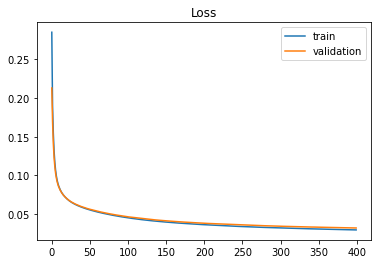

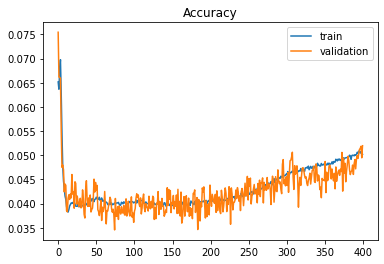

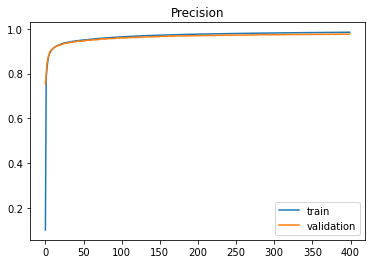

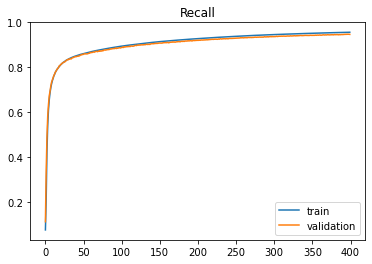

In [9]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

In [10]:
y_test_predict= autoencoderV2.predict(test_x)


Numero di vettori decodificati correttamente: 28133 su 51231 totali 
Rapporto: 54.914% 
Media num di errori per array: 1.273



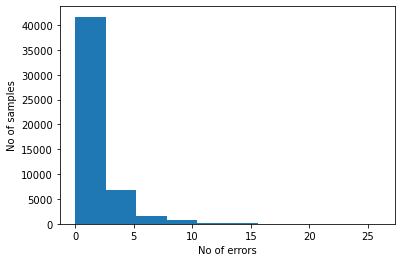

In [11]:
arr=results_info(test_y, y_test_predict,logdir)


In [ ]:
#Se è buono salvare (>90% rapporto vettori decodificati correttamente)

dir_model= os.path.join(logdir,"myModel")
autoencoderV2.save(dir_model)